# Segment Customers based on RFM Variables

In [1]:
# อิติปาระมิตา ติงสา อิติสัพพัญญะ มาคะตา
# อิติโพธิ มุนุปปัตโต อิติปิโส จะตะมะโน
# นะเมตตา โมกรุณา พุทธปราณี ธายินดี
# ยะเอ็นดู ยะหันตวา ธามัวเมา พุทพาเอา นะโมพุทธายะ

%matplotlib widget

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import plotly.offline as pyoff
import plotly.graph_objs as go

import datetime as dt
import feature_engine

from feature_engine.outliers import Winsorizer
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split
from keras.utils import np_utils 
import numpy as np

from pycaret.regression import * 
# from pycaret.classification import *


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Dataset

df = pd.read_csv('2019.csv')
df = df[['รหัสลูกค้า','ช่องทาง','CalendarDay','Week','Site_Key','Site_MediumText','Product_Champion','Article','Sales_Excld']]


df2 = pd.read_csv('2020.csv')
df2 = df2[['รหัสลูกค้า','ช่องทาง','CalendarDay','Week','Site_Key','Site_MediumText','Product_Champion','Article','Sales_Excld']]


df3 = pd.read_csv('2021.csv')
df3 = df3[['รหัสลูกค้า','ช่องทาง','CalendarDay','Week','Site_Key','Site_MediumText','Product_Champion','Article','Sales_Excld']]


df = df.append(df2, ignore_index = True)
df = df.append(df3, ignore_index = True)

df = df.rename(columns = {'รหัสลูกค้า': 'Customer_ID', 'ช่องทาง': 'Channel'}, inplace = False)

df[["Month", "Day", "Year"]] = df["CalendarDay"].str.split("/", expand = True)

df['CalendarDay'] = pd.to_datetime(df['CalendarDay'])


df = df[df['Product_Champion'].isin(['Egg', 'Other ', 'Poultry', 'Process Food', 'Process Meat', 'Swine']) & df['Site_Key'].isin(['S035','S154','S031'])]
# df = df[['รหัสลูกค้า','ช่องทาง','CalendarDay','Week','Site_Key','Site_MediumText','Product_Champion','Article_Key','Article','Sales_Excld']]
# 'Egg', 'Other', 'Poultry', 'Process Food', 'Process Meat', 'Swine'
# 'เบทาโกรช็อป สาขามุกดาหาร' , 'เบทาโกรช็อป สาขาธาตุพนม' ,'เบทาโกรช็อป สาขาหนองคาย'

df
# print(df)

Customer_ID       Channel CalendarDay        Week Site_Key  \
0                23     WHOLESALE  2019-04-01   4_W1_2019     S031   
1               798  FOOD SERVICE  2019-04-01   4_W1_2019     S035   
2              1116  FOOD SERVICE  2019-04-01   4_W1_2019     S154   
3               263     WHOLESALE  2019-04-01   4_W1_2019     S154   
4                19    INDUSTRIAL  2019-04-01   4_W1_2019     S031   
...             ...           ...         ...         ...      ...   
234675          341     WHOLESALE  2021-12-31  12_W5_2021     S035   
234676          695     WHOLESALE  2021-12-31  12_W5_2021     S035   
234677          308     WHOLESALE  2021-12-31  12_W5_2021     S154   
234678          431  FOOD SERVICE  2021-12-31  12_W5_2021     S154   
234679          695     WHOLESALE  2021-12-31  12_W5_2021     S035   

                 Site_MediumText Product_Champion  \
0        เบทาโกรช็อป สาขาหนองคาย          Poultry   
1       เบทาโกรช็อป สาขามุกดาหาร          Poultry   
2        เบทาโกรช็อป สาขาธาตุพนม     Process Meat   
3        เบทาโกรช็อป สาขาธาตุพนม          Poultry   
4        เบทาโกรช็อป สาขาหนองคาย          Poultry   
...                          ...              ...   
234675  เบทาโกรช็อป สาขามุกดาหาร            Swine   
234676  เบทาโกรช็อป สาขามุกดาหาร     Process Food   
234677   เบทาโกรช็อป สาขาธาตุพนม     Process Food   
234678   เบทาโกรช็อป สาขาธาตุพนม           Other    
234679  เบทาโกรช็อป สาขามุกดาหาร           Other    

                                         Article  Sales_Excld Month Day  Year  
0                       FR CK เลือดไก่ 5 ก้อน HB        25.00     4   1  2019  
1                  FR CK เลือดไก่ก้อน 10 ก้อน HB        40.00     4   1  2019  
2           SS CK BTG คอกเทลหนังบางกรอบ ACO 500ก        56.07     4   1  2019  
3                        FR CK ขาซีไก่ A BTG 1กก        80.00     4   1  2019  
4             FR CK ไก่ บ้านอิสานล้วง แพ็ค 1 ตัว        81.60     4   1  2019  
...                                          ...          ...   ...  ..   ...  
234675                   FR PK BTG กะโหลกหมู-2/K        36.72    12  31  2021  
234676  น้ำซุปหมูสูตรเข้มข้น/140g(50pack/carton)        36.45    12  31  2021  
234677          ST CK SBB&BL&SKIN BTG นักเก็ตไก่        28.04    12  31  2021  
234678           ซอสมะเขือเทศ ตราเด็กสมบูรณ์ 1kg        24.17    12  31  2021  
234679           BO EG BTG เต้าหู้ไข่อนามัยH120ก        22.42    12  31  2021  

[234680 rows x 12 columns]

In [3]:
df.shape

(234680, 12)

## Data Preparation

In [4]:
def summary(df, pred=None):
  obs = df.shape[0]
  types = df.dtypes
  counts = df.apply(lambda x: x.count())
  min = df.min()
  uniques = df.apply(lambda x: x.unique().shape[0])
  nulls = df.apply(lambda x: x.isnull().sum())
  print('Data shape:', df.shape)

  if pred is None:
        cols = ['types', 'counts', 'uniques', 'nulls', 'min']
        str = pd.concat([types, counts, uniques, nulls, min], axis = 1, sort=True)

  str.columns = cols
  dtypes = str.types.value_counts()
  print('___________________________\nData types:')
  print(str.types.value_counts())
  print('___________________________')
  return str

details = summary(df)
display(details.sort_values(by='nulls', ascending=False))

Data shape: (234680, 12)
___________________________
Data types:
object            9
datetime64[ns]    1
int64             1
float64           1
Name: types, dtype: int64
___________________________


types  counts  uniques  nulls  \
Article                   object  234680      987      0   
CalendarDay       datetime64[ns]  234680      865      0   
Channel                   object  234680        3      0   
Customer_ID                int64  234680     1754      0   
Day                       object  234680       31      0   
Month                     object  234680       12      0   
Product_Champion          object  234680        6      0   
Sales_Excld              float64  234680    20918      0   
Site_Key                  object  234680        3      0   
Site_MediumText           object  234680        3      0   
Week                      object  234680      143      0   
Year                      object  234680        3      0   

                                                   min  
Article           BA CK BTG ลูกชิ้นแฟนซีรักบี้ BH 500ก  
CalendarDay                        2019-04-01 00:00:00  
Channel                                   FOOD SERVICE  
Customer_ID                                          1  
Day                                                  1  
Month                                                1  
Product_Champion                                   Egg  
Sales_Excld                                      -0.01  
Site_Key                                          S031  
Site_MediumText                เบทาโกรช็อป สาขาธาตุพนม  
Week                                        10_W1_2019  
Year                                              2019

In [5]:
df.describe()

Customer_ID    Sales_Excld
count  234680.000000  234680.000000
mean      364.763486    2091.911358
std       384.380805    8081.662564
min         1.000000      -0.010000
25%       121.000000     500.000000
50%       228.000000     934.580000
75%       422.000000    1800.000000
max      1778.000000  811680.000000

In [6]:
df.isnull().mean()*100

Customer_ID         0.0
Channel             0.0
CalendarDay         0.0
Week                0.0
Site_Key            0.0
Site_MediumText     0.0
Product_Champion    0.0
Article             0.0
Sales_Excld         0.0
Month               0.0
Day                 0.0
Year                0.0
dtype: float64

In [7]:
df.loc[(df.Sales_Excld<1)]

Customer_ID       Channel CalendarDay        Week Site_Key  \
8359             29  FOOD SERVICE  2019-05-16   5_W3_2019     S031   
23796          1185  FOOD SERVICE  2019-07-27   7_W4_2019     S154   
25522           201  FOOD SERVICE  2019-08-05   8_W2_2019     S154   
45438           749  FOOD SERVICE  2019-11-06  11_W1_2019     S031   
47308           724  FOOD SERVICE  2019-11-14  11_W2_2019     S031   
...             ...           ...         ...         ...      ...   
234487          633  FOOD SERVICE  2021-12-30  12_W5_2021     S031   
234488          461     WHOLESALE  2021-12-30  12_W5_2021     S031   
234489          461     WHOLESALE  2021-12-30  12_W5_2021     S031   
234490          453     WHOLESALE  2021-12-30  12_W5_2021     S031   
234491          454     WHOLESALE  2021-12-30  12_W5_2021     S154   

                Site_MediumText Product_Champion  \
8359    เบทาโกรช็อป สาขาหนองคาย              Egg   
23796   เบทาโกรช็อป สาขาธาตุพนม     Process Meat   
25522   เบทาโกรช็อป สาขาธาตุพนม     Process Meat   
45438   เบทาโกรช็อป สาขาหนองคาย           Other    
47308   เบทาโกรช็อป สาขาหนองคาย     Process Food   
...                         ...              ...   
234487  เบทาโกรช็อป สาขาหนองคาย     Process Meat   
234488  เบทาโกรช็อป สาขาหนองคาย     Process Food   
234489  เบทาโกรช็อป สาขาหนองคาย     Process Food   
234490  เบทาโกรช็อป สาขาหนองคาย     Process Food   
234491  เบทาโกรช็อป สาขาธาตุพนม     Process Food   

                                         Article  Sales_Excld Month Day  Year  
8359                  Egg No.3 (Betagro) Pack 30          0.0     5  16  2019  
23796    SS P&C BTG เม็กซิกันชิโปเล่ชีส ACO 500ก          0.0     7  27  2019  
25522   SS P&C BTGอิตาเลียนออริกาโน่ชีส ACO 500ก          0.0     8   5  2019  
45438            ซอสมะเขือเทศ ตราเด็กสมบูรณ์ 1kg          0.0    11   6  2019  
47308     FY CK BL-K ชุบแป้งทอด JAPANESE KARAAGE          0.0    11  14  2019  
...                                          ...          ...   ...  ..   ...  
234487           BA P&C BTG ลูกชิ้นปรุงรส B 500ก          0.0    12  30  2021  
234488            RO CK BBK BTG BBQ SPICY 1KG FZ          0.0    12  30  2021  
234489           DC PK BTG กะเพราหมูโบราณ 1KG FZ          0.0    12  30  2021  
234490             FY CK BLK THE KARAAGE(JKHT-C)          0.0    12  30  2021  
234491          ST CK SBB&BL&SKIN BTG นักเก็ตไก่          0.0    12  30  2021  

[505 rows x 12 columns]

In [8]:
df = df[df.Sales_Excld > 10]
df

Customer_ID       Channel CalendarDay        Week Site_Key  \
0                23     WHOLESALE  2019-04-01   4_W1_2019     S031   
1               798  FOOD SERVICE  2019-04-01   4_W1_2019     S035   
2              1116  FOOD SERVICE  2019-04-01   4_W1_2019     S154   
3               263     WHOLESALE  2019-04-01   4_W1_2019     S154   
4                19    INDUSTRIAL  2019-04-01   4_W1_2019     S031   
...             ...           ...         ...         ...      ...   
234675          341     WHOLESALE  2021-12-31  12_W5_2021     S035   
234676          695     WHOLESALE  2021-12-31  12_W5_2021     S035   
234677          308     WHOLESALE  2021-12-31  12_W5_2021     S154   
234678          431  FOOD SERVICE  2021-12-31  12_W5_2021     S154   
234679          695     WHOLESALE  2021-12-31  12_W5_2021     S035   

                 Site_MediumText Product_Champion  \
0        เบทาโกรช็อป สาขาหนองคาย          Poultry   
1       เบทาโกรช็อป สาขามุกดาหาร          Poultry   
2        เบทาโกรช็อป สาขาธาตุพนม     Process Meat   
3        เบทาโกรช็อป สาขาธาตุพนม          Poultry   
4        เบทาโกรช็อป สาขาหนองคาย          Poultry   
...                          ...              ...   
234675  เบทาโกรช็อป สาขามุกดาหาร            Swine   
234676  เบทาโกรช็อป สาขามุกดาหาร     Process Food   
234677   เบทาโกรช็อป สาขาธาตุพนม     Process Food   
234678   เบทาโกรช็อป สาขาธาตุพนม           Other    
234679  เบทาโกรช็อป สาขามุกดาหาร           Other    

                                         Article  Sales_Excld Month Day  Year  
0                       FR CK เลือดไก่ 5 ก้อน HB        25.00     4   1  2019  
1                  FR CK เลือดไก่ก้อน 10 ก้อน HB        40.00     4   1  2019  
2           SS CK BTG คอกเทลหนังบางกรอบ ACO 500ก        56.07     4   1  2019  
3                        FR CK ขาซีไก่ A BTG 1กก        80.00     4   1  2019  
4             FR CK ไก่ บ้านอิสานล้วง แพ็ค 1 ตัว        81.60     4   1  2019  
...                                          ...          ...   ...  ..   ...  
234675                   FR PK BTG กะโหลกหมู-2/K        36.72    12  31  2021  
234676  น้ำซุปหมูสูตรเข้มข้น/140g(50pack/carton)        36.45    12  31  2021  
234677          ST CK SBB&BL&SKIN BTG นักเก็ตไก่        28.04    12  31  2021  
234678           ซอสมะเขือเทศ ตราเด็กสมบูรณ์ 1kg        24.17    12  31  2021  
234679           BO EG BTG เต้าหู้ไข่อนามัยH120ก        22.42    12  31  2021  

[234111 rows x 12 columns]

In [27]:
# #Removing the Null values from the data.
df = df[pd.notnull(df['Customer_ID'])]

In [28]:
df

Customer_ID       Channel CalendarDay        Week Site_Key  \
0                23     WHOLESALE  2019-04-01   4_W1_2019     S031   
1               798  FOOD SERVICE  2019-04-01   4_W1_2019     S035   
2              1116  FOOD SERVICE  2019-04-01   4_W1_2019     S154   
3               263     WHOLESALE  2019-04-01   4_W1_2019     S154   
4                19    INDUSTRIAL  2019-04-01   4_W1_2019     S031   
...             ...           ...         ...         ...      ...   
234675          341     WHOLESALE  2021-12-31  12_W5_2021     S035   
234676          695     WHOLESALE  2021-12-31  12_W5_2021     S035   
234677          308     WHOLESALE  2021-12-31  12_W5_2021     S154   
234678          431  FOOD SERVICE  2021-12-31  12_W5_2021     S154   
234679          695     WHOLESALE  2021-12-31  12_W5_2021     S035   

                 Site_MediumText Product_Champion  \
0        เบทาโกรช็อป สาขาหนองคาย          Poultry   
1       เบทาโกรช็อป สาขามุกดาหาร          Poultry   
2        เบทาโกรช็อป สาขาธาตุพนม     Process Meat   
3        เบทาโกรช็อป สาขาธาตุพนม          Poultry   
4        เบทาโกรช็อป สาขาหนองคาย          Poultry   
...                          ...              ...   
234675  เบทาโกรช็อป สาขามุกดาหาร            Swine   
234676  เบทาโกรช็อป สาขามุกดาหาร     Process Food   
234677   เบทาโกรช็อป สาขาธาตุพนม     Process Food   
234678   เบทาโกรช็อป สาขาธาตุพนม           Other    
234679  เบทาโกรช็อป สาขามุกดาหาร           Other    

                                         Article  Sales_Excld Month Day  Year  
0                       FR CK เลือดไก่ 5 ก้อน HB        25.00     4   1  2019  
1                  FR CK เลือดไก่ก้อน 10 ก้อน HB        40.00     4   1  2019  
2           SS CK BTG คอกเทลหนังบางกรอบ ACO 500ก        56.07     4   1  2019  
3                        FR CK ขาซีไก่ A BTG 1กก        80.00     4   1  2019  
4             FR CK ไก่ บ้านอิสานล้วง แพ็ค 1 ตัว        81.60     4   1  2019  
...                                          ...          ...   ...  ..   ...  
234675                   FR PK BTG กะโหลกหมู-2/K        36.72    12  31  2021  
234676  น้ำซุปหมูสูตรเข้มข้น/140g(50pack/carton)        36.45    12  31  2021  
234677          ST CK SBB&BL&SKIN BTG นักเก็ตไก่        28.04    12  31  2021  
234678           ซอสมะเขือเทศ ตราเด็กสมบูรณ์ 1kg        24.17    12  31  2021  
234679           BO EG BTG เต้าหู้ไข่อนามัยH120ก        22.42    12  31  2021  

[234111 rows x 12 columns]

In [35]:
FM_Table = df.groupby('Customer_ID').agg({'Customer_ID': lambda x:len(x),'Sales_Excld'  : lambda x:x.sum()})

GB = df.copy()

GB = df.groupby(['Year','Month','Customer_ID']).agg({'Customer_ID': lambda x:len(x),'Sales_Excld': lambda x:x.sum(),'CalendarDay' : lambda x: x.max()})
GB.rename(columns = {'Customer_ID' :'Frequency','Sales_Excld':'Monetary'},inplace= True)
GB.to_excel("Group.xlsx")
GB

# G_FM_Table = GB.groupby(['Year','Month','Customer_ID']).agg({'Customer_ID': lambda x:len(x),'Sales_Excld'  : lambda x:x.sum()})
# G_FM_Table.rename(columns = {'Customer_ID' :'Frequency','Sales_Excld':'Monetary'},inplace= True)


Frequency   Monetary CalendarDay
Year Month Customer_ID                                  
2019 10    1.0                 28   14667.00  2019-10-31
           2.0                 13   29790.00  2019-10-31
           3.0                 18   17784.00  2019-10-29
           4.0                 13  138476.86  2019-10-31
           5.0                134   98160.00  2019-10-31
...                           ...        ...         ...
2021 9     1774.0               2     414.95  2021-09-10
           1775.0               3    1779.05  2021-09-18
           1776.0               8    1282.81  2021-09-11
           1777.0               7    2653.10  2021-09-22
           1778.0               1     466.20  2021-09-20

[8682 rows x 3 columns]

In [10]:
GB = GB.reset_index()
GB

Year Month  Customer_ID  Frequency   Monetary CalendarDay
0     2021    10            1         30   21276.23  2021-10-30
1     2021    10            2         19   23436.00  2021-10-30
2     2021    10            3          8    7684.00  2021-10-26
3     2021    10            4          7  100902.08  2021-10-29
4     2021    10            5        125   78317.55  2021-10-30
...    ...   ...          ...        ...        ...         ...
1936  2022     1          705          4    6278.40  2022-01-27
1937  2022     1          706          1    1209.60  2022-01-26
1938  2022     1          707          6    4050.37  2022-01-29
1939  2022     1          708         22    5063.80  2022-01-25
1940  2022     1          709          5   11200.80  2022-01-31

[1941 rows x 6 columns]

In [11]:
df['Postdate'] = pd.to_datetime(df['CalendarDay'])

GB['Postdate'] = pd.to_datetime(GB['CalendarDay'])


In [12]:
df.isnull().mean()

GB.isnull().mean()

Year           0.0
Month          0.0
Customer_ID    0.0
Frequency      0.0
Monetary       0.0
CalendarDay    0.0
Postdate       0.0
dtype: float64

## RFM Analysis

In [13]:
NOW = dt.date(2022,2,1) 
df['Date'] = pd.DatetimeIndex(df.Postdate).date

GB['Date'] = pd.DatetimeIndex(GB.Postdate).date
GB

Year Month  Customer_ID  Frequency   Monetary CalendarDay   Postdate  \
0     2021    10            1         30   21276.23  2021-10-30 2021-10-30   
1     2021    10            2         19   23436.00  2021-10-30 2021-10-30   
2     2021    10            3          8    7684.00  2021-10-26 2021-10-26   
3     2021    10            4          7  100902.08  2021-10-29 2021-10-29   
4     2021    10            5        125   78317.55  2021-10-30 2021-10-30   
...    ...   ...          ...        ...        ...         ...        ...   
1936  2022     1          705          4    6278.40  2022-01-27 2022-01-27   
1937  2022     1          706          1    1209.60  2022-01-26 2022-01-26   
1938  2022     1          707          6    4050.37  2022-01-29 2022-01-29   
1939  2022     1          708         22    5063.80  2022-01-25 2022-01-25   
1940  2022     1          709          5   11200.80  2022-01-31 2022-01-31   

            Date  
0     2021-10-30  
1     2021-10-30  
2     2021-10-26  
3     2021-10-29  
4     2021-10-30  
...          ...  
1936  2022-01-27  
1937  2022-01-26  
1938  2022-01-29  
1939  2022-01-25  
1940  2022-01-31  

[1941 rows x 8 columns]

#### Recency

In [16]:
# df_recency = df.groupby(['Customer_ID'],as_index=False)['Date'].max()

# print(df_recency)
# df_recency.columns = ['Customer_ID','Last_Purchase_Date']

# df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
# df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)



GB_rfm = GB.groupby(['Year','Month','Customer_ID','Frequency','Monetary','CalendarDay'],as_index=False)['Date'].max()

GB_rfm.columns = ['Year','Month','Customer_ID','Frequency','Monetary','CalendarDay','Last_Purchase_Date']

GB_rfm['Recency'] = GB_rfm.Last_Purchase_Date.apply(lambda x:(NOW - x).days)
GB_rfm.drop(columns=['Last_Purchase_Date'],inplace=True)


In [17]:
# df_recency

Customer_ID  Recency
0              1        1
1              2        1
2              3        8
3              4        1
4              5        1
..           ...      ...
704          705        5
705          706        6
706          707        3
707          708        7
708          709        1

[709 rows x 2 columns]

In [18]:
GB_rfm

Year Month  Customer_ID  Frequency   Monetary CalendarDay  Recency
0     2021    10            1         30   21276.23  2021-10-30       94
1     2021    10            2         19   23436.00  2021-10-30       94
2     2021    10            3          8    7684.00  2021-10-26       98
3     2021    10            4          7  100902.08  2021-10-29       95
4     2021    10            5        125   78317.55  2021-10-30       94
...    ...   ...          ...        ...        ...         ...      ...
1936  2022     1          705          4    6278.40  2022-01-27        5
1937  2022     1          706          1    1209.60  2022-01-26        6
1938  2022     1          707          6    4050.37  2022-01-29        3
1939  2022     1          708         22    5063.80  2022-01-25        7
1940  2022     1          709          5   11200.80  2022-01-31        1

[1941 rows x 7 columns]

#### Frequency - Monetarty

In [17]:
# FM_Table = df.groupby('Customer_ID').agg({'Customer_ID': lambda x:len(x),'Sales_Excld'  : lambda x:x.sum()})
# FM_Table.rename(columns = {'Customer_ID' :'Frequency','Sales_Excld':'Monetary'},inplace= True)

# print(GB)
# G_FM_Table = GB.groupby(['Year','Month','Customer_ID']).agg({'Customer_ID': lambda x:len(x),'Sales_Excld'  : lambda x:x.sum()})
# G_FM_Table.rename(columns = {'Customer_ID' :'Frequency','Sales_Excld':'Monetary'},inplace= True)

      Year Month  Customer_ID  Sales_Excld CalendarDay   Postdate        Date
0     2021    10            1     21276.23  2021-10-30 2021-10-30  2021-10-30
1     2021    10            2     23436.00  2021-10-30 2021-10-30  2021-10-30
2     2021    10            3      7684.00  2021-10-26 2021-10-26  2021-10-26
3     2021    10            4    100902.08  2021-10-29 2021-10-29  2021-10-29
4     2021    10            5     78317.55  2021-10-30 2021-10-30  2021-10-30
...    ...   ...          ...          ...         ...        ...         ...
1936  2022     1          705      6278.40  2022-01-27 2022-01-27  2022-01-27
1937  2022     1          706      1209.60  2022-01-26 2022-01-26  2022-01-26
1938  2022     1          707      4050.37  2022-01-29 2022-01-29  2022-01-29
1939  2022     1          708      5063.80  2022-01-25 2022-01-25  2022-01-25
1940  2022     1          709     11200.80  2022-01-31 2022-01-31  2022-01-31

[1941 rows x 7 columns]


In [18]:
# FM_Table

Frequency   Monetary
Customer_ID                      
1                  104   77560.83
2                   85  121976.60
3                   34   31417.00
4                  128  950734.03
5                  465  313464.16
...                ...        ...
705                  4    6278.40
706                  1    1209.60
707                  6    4050.37
708                 22    5063.80
709                  5   11200.80

[709 rows x 2 columns]

In [19]:
# G_FM_Table

Frequency   Monetary
Year Month Customer_ID                      
2021 10    1                    1   21276.23
           2                    1   23436.00
           3                    1    7684.00
           4                    1  100902.08
           5                    1   78317.55
...                           ...        ...
2022 1     705                  1    6278.40
           706                  1    1209.60
           707                  1    4050.37
           708                  1    5063.80
           709                  1   11200.80

[1941 rows x 2 columns]

In [93]:
# RFM_Table = df_recency.merge(FM_Table,left_on='Customer_ID',right_on='Customer_ID')
# RFM_Table['FM_Avg'] = (RFM_Table['Frequency'] * RFM_Table['Monetary'])/2
# RFM_Table.to_excel("RFM_Table.xlsx")
# RFM_Table

RFM_Table = GB_rfm[(GB_rfm['Year'] == '2021') & (GB_rfm['Month'] == '10')].copy().reset_index()

RFM_Table['FM_Avg'] = (RFM_Table['Frequency'] * RFM_Table['Monetary'])/2
RFM_Table.to_excel("RFM_Table.xlsx")
RFM_Table

index  Year Month  Customer_ID  Frequency    Monetary CalendarDay  \
0        0  2021    10            1         30    21276.23  2021-10-30   
1        1  2021    10            2         19    23436.00  2021-10-30   
2        2  2021    10            3          8     7684.00  2021-10-26   
3        3  2021    10            4          7   100902.08  2021-10-29   
4        4  2021    10            5        125    78317.55  2021-10-30   
5        5  2021    10            8          4     2900.00  2021-10-18   
6        6  2021    10            9          4     4052.79  2021-10-04   
7        7  2021    10           10         15    88244.00  2021-10-28   
8        8  2021    10           13          2     2640.00  2021-10-25   
9        9  2021    10           14         19   219270.80  2021-10-25   
10      10  2021    10           15          4     2910.00  2021-10-25   
11      11  2021    10           16          1     2702.80  2021-10-23   
12      12  2021    10           17          3    25813.20  2021-10-11   
13      13  2021    10           18          8    13499.50  2021-10-29   
14      14  2021    10           19          7    11390.00  2021-10-27   
15      15  2021    10           20         12    17247.67  2021-10-27   
16      16  2021    10           22         27    67166.00  2021-10-30   
17      17  2021    10           23         55    45913.92  2021-10-30   
18      18  2021    10           24          2     1980.00  2021-10-26   
19      19  2021    10           25          2     2040.00  2021-10-23   
20      20  2021    10           28          2      176.00  2021-10-19   
21      21  2021    10           29         10    12381.00  2021-10-26   
22      22  2021    10           31          5     6272.30  2021-10-21   
23      23  2021    10           32         18    16271.27  2021-10-30   
24      24  2021    10           34         10     6819.00  2021-10-18   
25      25  2021    10           35          1     5400.00  2021-10-19   
26      26  2021    10           36         21    21494.18  2021-10-30   
27      27  2021    10           39         17     1998.88  2021-10-30   
28      28  2021    10           40         28    30875.00  2021-10-30   
29      29  2021    10           41         23    42060.00  2021-10-28   
30      30  2021    10           42          3      322.71  2021-10-28   
31      31  2021    10           44          3    10470.00  2021-10-02   
32      32  2021    10           45          7    17832.00  2021-10-29   
33      33  2021    10           46         16    66520.00  2021-10-28   
34      34  2021    10           47         23    40495.34  2021-10-30   
35      35  2021    10           49          4      385.52  2021-10-22   
36      36  2021    10           50          2      650.00  2021-10-18   
37      37  2021    10           52          2     1579.44  2021-10-13   
38      38  2021    10           55         58    51638.95  2021-10-30   
39      39  2021    10           56         42    18645.00  2021-10-29   
40      40  2021    10           58        156   104347.95  2021-10-30   
41      41  2021    10           59          7     3318.00  2021-10-28   
42      42  2021    10           62          7    15788.00  2021-10-28   
43      43  2021    10           63         10     9250.00  2021-10-28   
44      44  2021    10           65          1    21532.71  2021-10-07   
45      45  2021    10           66         14   105320.00  2021-10-29   
46      46  2021    10           67          4     1074.16  2021-10-25   
47      47  2021    10           70          6    12234.40  2021-10-30   
48      48  2021    10           71         63   191509.66  2021-10-30   
49      49  2021    10           75          6      544.57  2021-10-09   
50      50  2021    10           76         14    66428.86  2021-10-26   
51      51  2021    10           77         28    35233.00  2021-10-29   
52      52  2021    10           78          3      829.67  2021-10-22   
53      5

In [94]:
segmented_rfm = RFM_Table.copy()

segmented_rfm = segmented_rfm[['Year', 'Month', 'CalendarDay', 'Customer_ID','Recency','Frequency','Monetary','FM_Avg']]
# segmented_rfm = 
segmented_rfm


Year Month CalendarDay  Customer_ID  Recency  Frequency    Monetary  \
0    2021    10  2021-10-30            1       94         30    21276.23   
1    2021    10  2021-10-30            2       94         19    23436.00   
2    2021    10  2021-10-26            3       98          8     7684.00   
3    2021    10  2021-10-29            4       95          7   100902.08   
4    2021    10  2021-10-30            5       94        125    78317.55   
5    2021    10  2021-10-18            8      106          4     2900.00   
6    2021    10  2021-10-04            9      120          4     4052.79   
7    2021    10  2021-10-28           10       96         15    88244.00   
8    2021    10  2021-10-25           13       99          2     2640.00   
9    2021    10  2021-10-25           14       99         19   219270.80   
10   2021    10  2021-10-25           15       99          4     2910.00   
11   2021    10  2021-10-23           16      101          1     2702.80   
12   2021    10  2021-10-11           17      113          3    25813.20   
13   2021    10  2021-10-29           18       95          8    13499.50   
14   2021    10  2021-10-27           19       97          7    11390.00   
15   2021    10  2021-10-27           20       97         12    17247.67   
16   2021    10  2021-10-30           22       94         27    67166.00   
17   2021    10  2021-10-30           23       94         55    45913.92   
18   2021    10  2021-10-26           24       98          2     1980.00   
19   2021    10  2021-10-23           25      101          2     2040.00   
20   2021    10  2021-10-19           28      105          2      176.00   
21   2021    10  2021-10-26           29       98         10    12381.00   
22   2021    10  2021-10-21           31      103          5     6272.30   
23   2021    10  2021-10-30           32       94         18    16271.27   
24   2021    10  2021-10-18           34      106         10     6819.00   
25   2021    10  2021-10-19           35      105          1     5400.00   
26   2021    10  2021-10-30           36       94         21    21494.18   
27   2021    10  2021-10-30           39       94         17     1998.88   
28   2021    10  2021-10-30           40       94         28    30875.00   
29   2021    10  2021-10-28           41       96         23    42060.00   
30   2021    10  2021-10-28           42       96          3      322.71   
31   2021    10  2021-10-02           44      122          3    10470.00   
32   2021    10  2021-10-29           45       95          7    17832.00   
33   2021    10  2021-10-28           46       96         16    66520.00   
34   2021    10  2021-10-30           47       94         23    40495.34   
35   2021    10  2021-10-22           49      102          4      385.52   
36   2021    10  2021-10-18           50      106          2      650.00   
37   2021    10  2021-10-13           52      111          2     1579.44   
38   2021    10  2021-10-30           55       94         58    51638.95   
39   2021    10  2021-10-29           56       95         42    18645.00   
40   2021    10  2021-10-30           58       94        156   104347.95   
41   2021    10  2021-10-28           59       96          7     3318.00   
42   2021    10  2021-10-28           62       96          7    15788.00   
43   2021    10  2021-10-28           63       96         10     9250.00   
44   2021    10  2021-10-07           65      117          1    21532.71   
45   2021    10  2021-10-29           66       95         14   105320.00   
46   2021    10  2021-10-25           67       99          4     1074.16   
47   2021    10  2021-10-30           70       94          6    12234.40   
48   2021    10  2021-10-30           71       94         63   191509.66   
49   2021    10  2021-10-09           75      115          6      544.57   
50   2021    10  2021-10-26           76       98         14    66428.86   
51   2021    10  2021-10-29           77       95    

In [95]:
quantiles = RFM_Table.quantile(q=[0.2, 0.4, 0.6, 0.8])
quantiles = quantiles.to_dict()

In [96]:
def RScore(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1
    
def FMScore(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 4
    else:
        return 5


In [97]:
segmented_rfm['R_Score'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_Score'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_Score'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles))
segmented_rfm['FM_Score'] = segmented_rfm['FM_Avg'].apply(FMScore, args=('FM_Avg',quantiles))
segmented_rfm['RFM_Segment'] = segmented_rfm.R_Score.map(str)+segmented_rfm.F_Score.map(str)+segmented_rfm.M_Score.map(str)
segmented_rfm['RFM_Score'] = segmented_rfm[['R_Score','F_Score','M_Score']].sum(axis=1)


segmented_rfm

Year Month CalendarDay  Customer_ID  Recency  Frequency    Monetary  \
0    2021    10  2021-10-30            1       94         30    21276.23   
1    2021    10  2021-10-30            2       94         19    23436.00   
2    2021    10  2021-10-26            3       98          8     7684.00   
3    2021    10  2021-10-29            4       95          7   100902.08   
4    2021    10  2021-10-30            5       94        125    78317.55   
5    2021    10  2021-10-18            8      106          4     2900.00   
6    2021    10  2021-10-04            9      120          4     4052.79   
7    2021    10  2021-10-28           10       96         15    88244.00   
8    2021    10  2021-10-25           13       99          2     2640.00   
9    2021    10  2021-10-25           14       99         19   219270.80   
10   2021    10  2021-10-25           15       99          4     2910.00   
11   2021    10  2021-10-23           16      101          1     2702.80   
12   2021    10  2021-10-11           17      113          3    25813.20   
13   2021    10  2021-10-29           18       95          8    13499.50   
14   2021    10  2021-10-27           19       97          7    11390.00   
15   2021    10  2021-10-27           20       97         12    17247.67   
16   2021    10  2021-10-30           22       94         27    67166.00   
17   2021    10  2021-10-30           23       94         55    45913.92   
18   2021    10  2021-10-26           24       98          2     1980.00   
19   2021    10  2021-10-23           25      101          2     2040.00   
20   2021    10  2021-10-19           28      105          2      176.00   
21   2021    10  2021-10-26           29       98         10    12381.00   
22   2021    10  2021-10-21           31      103          5     6272.30   
23   2021    10  2021-10-30           32       94         18    16271.27   
24   2021    10  2021-10-18           34      106         10     6819.00   
25   2021    10  2021-10-19           35      105          1     5400.00   
26   2021    10  2021-10-30           36       94         21    21494.18   
27   2021    10  2021-10-30           39       94         17     1998.88   
28   2021    10  2021-10-30           40       94         28    30875.00   
29   2021    10  2021-10-28           41       96         23    42060.00   
30   2021    10  2021-10-28           42       96          3      322.71   
31   2021    10  2021-10-02           44      122          3    10470.00   
32   2021    10  2021-10-29           45       95          7    17832.00   
33   2021    10  2021-10-28           46       96         16    66520.00   
34   2021    10  2021-10-30           47       94         23    40495.34   
35   2021    10  2021-10-22           49      102          4      385.52   
36   2021    10  2021-10-18           50      106          2      650.00   
37   2021    10  2021-10-13           52      111          2     1579.44   
38   2021    10  2021-10-30           55       94         58    51638.95   
39   2021    10  2021-10-29           56       95         42    18645.00   
40   2021    10  2021-10-30           58       94        156   104347.95   
41   2021    10  2021-10-28           59       96          7     3318.00   
42   2021    10  2021-10-28           62       96          7    15788.00   
43   2021    10  2021-10-28           63       96         10     9250.00   
44   2021    10  2021-10-07           65      117          1    21532.71   
45   2021    10  2021-10-29           66       95         14   105320.00   
46   2021    10  2021-10-25           67       99          4     1074.16   
47   2021    10  2021-10-30           70       94          6    12234.40   
48   2021    10  2021-10-30           71       94         63   191509.66   
49   2021    10  2021-10-09           75      115          6      544.57   
50   2021    10  2021-10-26           76       98         14    66428.86   
51   2021    10  2021-10-29           77       95    

In [98]:
segmented_rfm['RFM_Score'].unique()
# segmented_rfm.to_excel("segmented_rfm_1.xlsx")
segmented_rfm

Year Month CalendarDay  Customer_ID  Recency  Frequency    Monetary  \
0    2021    10  2021-10-30            1       94         30    21276.23   
1    2021    10  2021-10-30            2       94         19    23436.00   
2    2021    10  2021-10-26            3       98          8     7684.00   
3    2021    10  2021-10-29            4       95          7   100902.08   
4    2021    10  2021-10-30            5       94        125    78317.55   
5    2021    10  2021-10-18            8      106          4     2900.00   
6    2021    10  2021-10-04            9      120          4     4052.79   
7    2021    10  2021-10-28           10       96         15    88244.00   
8    2021    10  2021-10-25           13       99          2     2640.00   
9    2021    10  2021-10-25           14       99         19   219270.80   
10   2021    10  2021-10-25           15       99          4     2910.00   
11   2021    10  2021-10-23           16      101          1     2702.80   
12   2021    10  2021-10-11           17      113          3    25813.20   
13   2021    10  2021-10-29           18       95          8    13499.50   
14   2021    10  2021-10-27           19       97          7    11390.00   
15   2021    10  2021-10-27           20       97         12    17247.67   
16   2021    10  2021-10-30           22       94         27    67166.00   
17   2021    10  2021-10-30           23       94         55    45913.92   
18   2021    10  2021-10-26           24       98          2     1980.00   
19   2021    10  2021-10-23           25      101          2     2040.00   
20   2021    10  2021-10-19           28      105          2      176.00   
21   2021    10  2021-10-26           29       98         10    12381.00   
22   2021    10  2021-10-21           31      103          5     6272.30   
23   2021    10  2021-10-30           32       94         18    16271.27   
24   2021    10  2021-10-18           34      106         10     6819.00   
25   2021    10  2021-10-19           35      105          1     5400.00   
26   2021    10  2021-10-30           36       94         21    21494.18   
27   2021    10  2021-10-30           39       94         17     1998.88   
28   2021    10  2021-10-30           40       94         28    30875.00   
29   2021    10  2021-10-28           41       96         23    42060.00   
30   2021    10  2021-10-28           42       96          3      322.71   
31   2021    10  2021-10-02           44      122          3    10470.00   
32   2021    10  2021-10-29           45       95          7    17832.00   
33   2021    10  2021-10-28           46       96         16    66520.00   
34   2021    10  2021-10-30           47       94         23    40495.34   
35   2021    10  2021-10-22           49      102          4      385.52   
36   2021    10  2021-10-18           50      106          2      650.00   
37   2021    10  2021-10-13           52      111          2     1579.44   
38   2021    10  2021-10-30           55       94         58    51638.95   
39   2021    10  2021-10-29           56       95         42    18645.00   
40   2021    10  2021-10-30           58       94        156   104347.95   
41   2021    10  2021-10-28           59       96          7     3318.00   
42   2021    10  2021-10-28           62       96          7    15788.00   
43   2021    10  2021-10-28           63       96         10     9250.00   
44   2021    10  2021-10-07           65      117          1    21532.71   
45   2021    10  2021-10-29           66       95         14   105320.00   
46   2021    10  2021-10-25           67       99          4     1074.16   
47   2021    10  2021-10-30           70       94          6    12234.40   
48   2021    10  2021-10-30           71       94         63   191509.66   
49   2021    10  2021-10-09           75      115          6      544.57   
50   2021    10  2021-10-26           76       98         14    66428.86   
51   2021    10  2021-10-29           77       95    

## 3D Segmentation (125 Platten)

In [99]:
RBChamp = ['555', '554', '544', '545', '454', '455', '445']

RBLoyal = ['543', '444', '435', '355', '354', '345', '344', '335']

RBPoLoyal = ['553', '551', '552', '541', '542', '533', '532', '531', '452',
             '451', '442', '441', '431', '453', '433', '432', '423', '353',
             '352', '351', '342', '341', '333', '323']

RBNewCust = ['512', '511', '422', '421', '412', '411', '311']

RBPromis = ['525', '524', '523', '522', '521', '515', '514', '513', '425',
            '424', '413', '414', '415', '315', '314', '313']

RBNeedAttent = ['535', '534', '443', '434', '343', '334', '325', '324']

RBAbout = ['331', '321', '312', '221', '213', '231', '241', '251']

RBrisk = ['255', '254', '245', '244', '253', '252', '243', '242', '235', '234',
          '225', '224', '153', '152', '145', '143', '142', '135', '134', '133',
          '125', '124']

RBCantlose = ['155', '154', '144', '214', '215', '115', '114', '113']

RBHibernate = ['332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211']
RBLost = ['111', '112', '121', '131', '141', '151']


In [100]:
segmented_rfm['Class'] = np.where((segmented_rfm.RFM_Segment.isin(RBChamp)), 'Champion',
                                  np.where((segmented_rfm.RFM_Segment.isin(RBLoyal)), 'Loyal',
                                           np.where((segmented_rfm.RFM_Segment.isin(RBPoLoyal)), 'Potential Loyal',
                                                    np.where((segmented_rfm.RFM_Segment.isin(RBNewCust)), 'New Customer',
                                                             np.where((segmented_rfm.RFM_Segment.isin(RBPromis)), 'Promising',
                                                                      np.where((segmented_rfm.RFM_Segment.isin(RBNeedAttent)), 'Need Attention',
                                                                               np.where((segmented_rfm.RFM_Segment.isin(RBAbout)), 'About to sleep',
                                                                                        np.where((segmented_rfm.RFM_Segment.isin(RBrisk)), 'At risk',
                                                                                                 np.where((segmented_rfm.RFM_Segment.isin(RBCantlose)), "Can't lose them",
                                                                                                          np.where((segmented_rfm.RFM_Segment.isin(RBHibernate)), 'Hibernating',
                                                                                                                   np.where((segmented_rfm.RFM_Segment.isin(RBLost)), 'Lost', 0)))))))))))



Champion = segmented_rfm[segmented_rfm['Class'] == 'Champion']
Loyal = segmented_rfm[segmented_rfm['Class'] == 'Loyal']
PoLoyal = segmented_rfm[segmented_rfm['Class'] == 'Potential Loyal']
NewCust = segmented_rfm[segmented_rfm['Class'] == 'New Customer']
Promis = segmented_rfm[segmented_rfm['Class'] == 'Promising']
NeedAttent = segmented_rfm[segmented_rfm['Class'] == 'Need Attention']
About = segmented_rfm[segmented_rfm['Class'] == 'About to sleep']
risk = segmented_rfm[segmented_rfm['Class'] == 'At risk']
Cantlose = segmented_rfm[segmented_rfm['Class'] == "Can't lose them"]
Hibernate = segmented_rfm[segmented_rfm['Class'] == 'Hibernating']
Lost = segmented_rfm[segmented_rfm['Class'] == 'Lost']
notseg = segmented_rfm[segmented_rfm['Class'] == 0 ]

print('Champion: ', len(segmented_rfm[segmented_rfm['Class'] == 'Champion']))
print('Loyal: ', len(segmented_rfm[segmented_rfm['Class'] == 'Loyal']))
print('Potential Loyal: ', len(segmented_rfm[segmented_rfm['Class'] == 'Potential Loyal']))
print('New Customer: ', len(segmented_rfm[segmented_rfm['Class'] == 'New Customer']))
print('Promising: ', len(segmented_rfm[segmented_rfm['Class'] == 'Promising']))
print('Need Attention: ', len(segmented_rfm[segmented_rfm['Class'] == 'Need Attention']))
print('About to sleep: ', len(segmented_rfm[segmented_rfm['Class'] == 'About to sleep']))
print('At risk: ', len(segmented_rfm[segmented_rfm['Class'] == 'At risk']))
print("Can't lose Them: ", len(segmented_rfm[segmented_rfm['Class'] == "Can't lose them"]))
print('Hibernating: ', len(segmented_rfm[segmented_rfm['Class'] == 'Hibernating']))
print('Lost: ', len(segmented_rfm[segmented_rfm['Class'] == 'Lost']))
print('Not Segment: ', len(segmented_rfm[segmented_rfm['Class'] == 0]))

segmented_rfm

Champion:  91
Loyal:  53
Potential Loyal:  65
New Customer:  16
Promising:  14
Need Attention:  43
About to sleep:  22
At risk:  20
Can't lose Them:  12
Hibernating:  77
Lost:  57
Not Segment:  0


Year Month CalendarDay  Customer_ID  Recency  Frequency    Monetary  \
0    2021    10  2021-10-30            1       94         30    21276.23   
1    2021    10  2021-10-30            2       94         19    23436.00   
2    2021    10  2021-10-26            3       98          8     7684.00   
3    2021    10  2021-10-29            4       95          7   100902.08   
4    2021    10  2021-10-30            5       94        125    78317.55   
5    2021    10  2021-10-18            8      106          4     2900.00   
6    2021    10  2021-10-04            9      120          4     4052.79   
7    2021    10  2021-10-28           10       96         15    88244.00   
8    2021    10  2021-10-25           13       99          2     2640.00   
9    2021    10  2021-10-25           14       99         19   219270.80   
10   2021    10  2021-10-25           15       99          4     2910.00   
11   2021    10  2021-10-23           16      101          1     2702.80   
12   2021    10  2021-10-11           17      113          3    25813.20   
13   2021    10  2021-10-29           18       95          8    13499.50   
14   2021    10  2021-10-27           19       97          7    11390.00   
15   2021    10  2021-10-27           20       97         12    17247.67   
16   2021    10  2021-10-30           22       94         27    67166.00   
17   2021    10  2021-10-30           23       94         55    45913.92   
18   2021    10  2021-10-26           24       98          2     1980.00   
19   2021    10  2021-10-23           25      101          2     2040.00   
20   2021    10  2021-10-19           28      105          2      176.00   
21   2021    10  2021-10-26           29       98         10    12381.00   
22   2021    10  2021-10-21           31      103          5     6272.30   
23   2021    10  2021-10-30           32       94         18    16271.27   
24   2021    10  2021-10-18           34      106         10     6819.00   
25   2021    10  2021-10-19           35      105          1     5400.00   
26   2021    10  2021-10-30           36       94         21    21494.18   
27   2021    10  2021-10-30           39       94         17     1998.88   
28   2021    10  2021-10-30           40       94         28    30875.00   
29   2021    10  2021-10-28           41       96         23    42060.00   
30   2021    10  2021-10-28           42       96          3      322.71   
31   2021    10  2021-10-02           44      122          3    10470.00   
32   2021    10  2021-10-29           45       95          7    17832.00   
33   2021    10  2021-10-28           46       96         16    66520.00   
34   2021    10  2021-10-30           47       94         23    40495.34   
35   2021    10  2021-10-22           49      102          4      385.52   
36   2021    10  2021-10-18           50      106          2      650.00   
37   2021    10  2021-10-13           52      111          2     1579.44   
38   2021    10  2021-10-30           55       94         58    51638.95   
39   2021    10  2021-10-29           56       95         42    18645.00   
40   2021    10  2021-10-30           58       94        156   104347.95   
41   2021    10  2021-10-28           59       96          7     3318.00   
42   2021    10  2021-10-28           62       96          7    15788.00   
43   2021    10  2021-10-28           63       96         10     9250.00   
44   2021    10  2021-10-07           65      117          1    21532.71   
45   2021    10  2021-10-29           66       95         14   105320.00   
46   2021    10  2021-10-25           67       99          4     1074.16   
47   2021    10  2021-10-30           70       94          6    12234.40   
48   2021    10  2021-10-30           71       94         63   191509.66   
49   2021    10  2021-10-09           75      115          6      544.57   
50   2021    10  2021-10-26           76       98         14    66428.86   
51   2021    10  2021-10-29           77       95    

In [101]:
segmented_rfm['RFM_Score'].unique()
# segmented_rfm.to_excel("segmented_rfm_1.xlsx")
segmented_rfm

Year Month CalendarDay  Customer_ID  Recency  Frequency    Monetary  \
0    2021    10  2021-10-30            1       94         30    21276.23   
1    2021    10  2021-10-30            2       94         19    23436.00   
2    2021    10  2021-10-26            3       98          8     7684.00   
3    2021    10  2021-10-29            4       95          7   100902.08   
4    2021    10  2021-10-30            5       94        125    78317.55   
5    2021    10  2021-10-18            8      106          4     2900.00   
6    2021    10  2021-10-04            9      120          4     4052.79   
7    2021    10  2021-10-28           10       96         15    88244.00   
8    2021    10  2021-10-25           13       99          2     2640.00   
9    2021    10  2021-10-25           14       99         19   219270.80   
10   2021    10  2021-10-25           15       99          4     2910.00   
11   2021    10  2021-10-23           16      101          1     2702.80   
12   2021    10  2021-10-11           17      113          3    25813.20   
13   2021    10  2021-10-29           18       95          8    13499.50   
14   2021    10  2021-10-27           19       97          7    11390.00   
15   2021    10  2021-10-27           20       97         12    17247.67   
16   2021    10  2021-10-30           22       94         27    67166.00   
17   2021    10  2021-10-30           23       94         55    45913.92   
18   2021    10  2021-10-26           24       98          2     1980.00   
19   2021    10  2021-10-23           25      101          2     2040.00   
20   2021    10  2021-10-19           28      105          2      176.00   
21   2021    10  2021-10-26           29       98         10    12381.00   
22   2021    10  2021-10-21           31      103          5     6272.30   
23   2021    10  2021-10-30           32       94         18    16271.27   
24   2021    10  2021-10-18           34      106         10     6819.00   
25   2021    10  2021-10-19           35      105          1     5400.00   
26   2021    10  2021-10-30           36       94         21    21494.18   
27   2021    10  2021-10-30           39       94         17     1998.88   
28   2021    10  2021-10-30           40       94         28    30875.00   
29   2021    10  2021-10-28           41       96         23    42060.00   
30   2021    10  2021-10-28           42       96          3      322.71   
31   2021    10  2021-10-02           44      122          3    10470.00   
32   2021    10  2021-10-29           45       95          7    17832.00   
33   2021    10  2021-10-28           46       96         16    66520.00   
34   2021    10  2021-10-30           47       94         23    40495.34   
35   2021    10  2021-10-22           49      102          4      385.52   
36   2021    10  2021-10-18           50      106          2      650.00   
37   2021    10  2021-10-13           52      111          2     1579.44   
38   2021    10  2021-10-30           55       94         58    51638.95   
39   2021    10  2021-10-29           56       95         42    18645.00   
40   2021    10  2021-10-30           58       94        156   104347.95   
41   2021    10  2021-10-28           59       96          7     3318.00   
42   2021    10  2021-10-28           62       96          7    15788.00   
43   2021    10  2021-10-28           63       96         10     9250.00   
44   2021    10  2021-10-07           65      117          1    21532.71   
45   2021    10  2021-10-29           66       95         14   105320.00   
46   2021    10  2021-10-25           67       99          4     1074.16   
47   2021    10  2021-10-30           70       94          6    12234.40   
48   2021    10  2021-10-30           71       94         63   191509.66   
49   2021    10  2021-10-09           75      115          6      544.57   
50   2021    10  2021-10-26           76       98         14    66428.86   
51   2021    10  2021-10-29           77       95    

In [102]:
# Champion
# Loyal
# PoLoyal 
# NewCust
# Promis
# NeedAttent
# About
# risk
# Cantlose
# Hibernate
# Lost

xChampion = Champion.Recency
xLoyal = Loyal.Recency
xPoLoyal = PoLoyal.Recency
xNewCust = NewCust.Recency
xPromis = Promis.Recency
xNeedAttent = NeedAttent.Recency
xAbout = About.Recency
xrisk = risk.Recency
xCantlose = Cantlose.Recency
xHibernate = Hibernate.Recency
xLost = Lost.Recency

yChampion = Champion.Frequency
yLoyal = Loyal.Frequency
yPoLoyal = PoLoyal.Frequency
yNewCust = NewCust.Frequency
yPromis = Promis.Frequency
yNeedAttent = NeedAttent.Frequency
yAbout = About.Frequency
yrisk = risk.Frequency
yCantlose = Cantlose.Frequency
yHibernate = Hibernate.Frequency
yLost = Lost.Frequency

zChampion = Champion.Monetary
zLoyal = Loyal.Monetary
zPoLoyal = PoLoyal.Monetary
zNewCust = NewCust.Monetary
zPromis = Promis.Monetary
zNeedAttent = NeedAttent.Monetary
zAbout = About.Monetary
zrisk = risk.Monetary
zCantlose = Cantlose.Monetary
zHibernate = Hibernate.Monetary
zLost = Lost.Monetary

logyChampion = np.log(Champion.Frequency)
logyLoyal = np.log(Loyal.Frequency)
logyPoLoyal = np.log(PoLoyal.Frequency)
logyNewCust = np.log(NewCust.Frequency)
logyPromis = np.log(Promis.Frequency)
logyNeedAttent = np.log(NeedAttent.Frequency)
logyAbout = np.log(About.Frequency)
logyrisk = np.log(risk.Frequency)
logyCantlose = np.log(Cantlose.Frequency)
logyHibernate = np.log(Hibernate.Frequency)
logyLost = np.log(Lost.Frequency)

logzChampion = np.log(Champion.Monetary)
logzLoyal = np.log(Loyal.Monetary)
logzPoLoyal = np.log(PoLoyal.Monetary)
logzNewCust = np.log(NewCust.Monetary)
logzPromis = np.log(Promis.Monetary)
logzNeedAttent = np.log(NeedAttent.Monetary)
logzAbout = np.log(About.Monetary)
logzrisk = np.log(risk.Monetary)
logzCantlose = np.log(Cantlose.Monetary)
logzHibernate = np.log(Hibernate.Monetary)
logzLost = np.log(Lost.Monetary)


#### RFM Graph

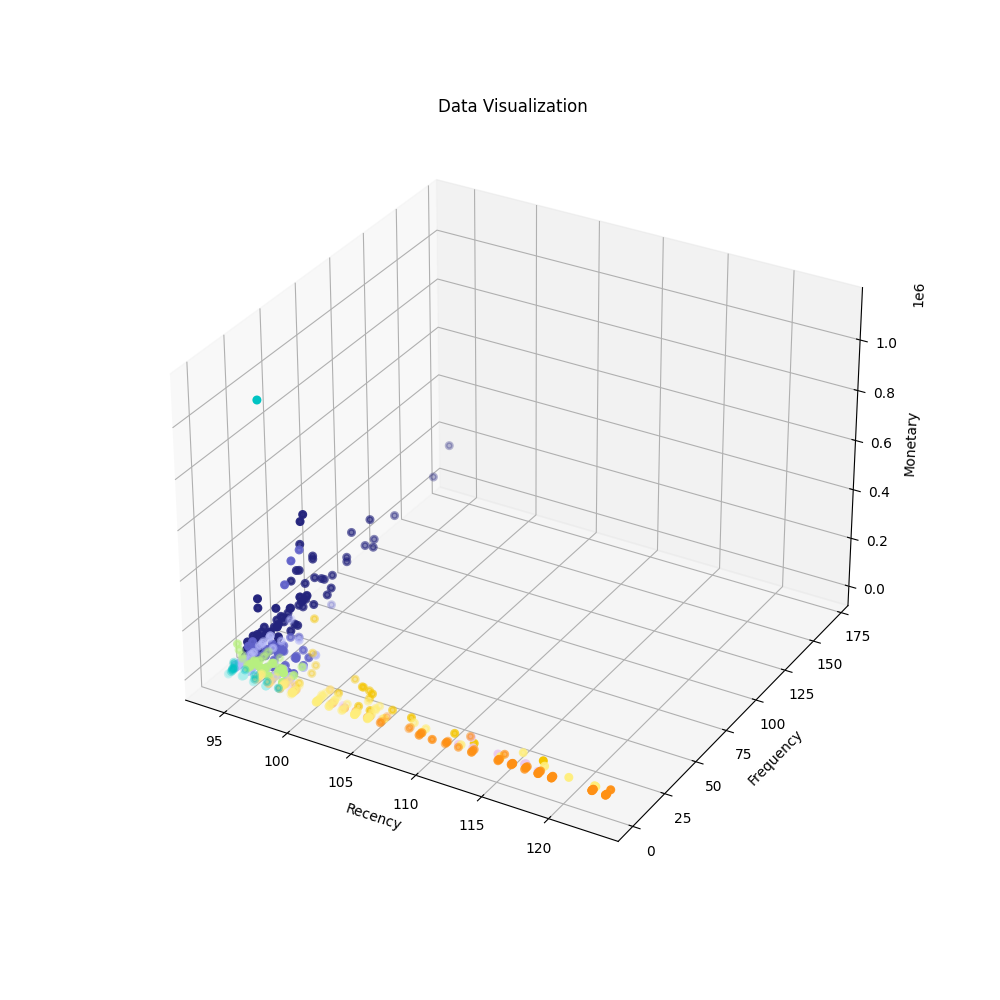

In [103]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
plt.title('Data Visualization')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

ax.scatter(xChampion, yChampion, zChampion, c='#23237C', linewidth=2);
ax.scatter(xLoyal, yLoyal, zLoyal, c='#6061C9', linewidth=2);
ax.scatter(xPoLoyal, yPoLoyal, zPoLoyal, c='#B5B8F9', linewidth=2);
ax.scatter(xNewCust, yNewCust, zNewCust, c='#ABEEEC', linewidth=2);
ax.scatter(xPromis, yPromis, zPromis, c='#01C4C3', linewidth=2);
ax.scatter(xNeedAttent, yNeedAttent, zNeedAttent, c='#B8F080', linewidth=2);
ax.scatter(xAbout, yAbout, zAbout, c='#FBC57E', linewidth=2);
ax.scatter(xrisk, yrisk, zrisk, c='#F4C500', linewidth=2);
ax.scatter(xCantlose, yCantlose, zCantlose, c='#EBC9EE', linewidth=2);
ax.scatter(xHibernate, yHibernate, zHibernate, c='#FFEE7C', linewidth=2);
ax.scatter(xLost, yLost, zLost, c='#FF9014', linewidth=2);

#### Rlog(F)log(M) Graph

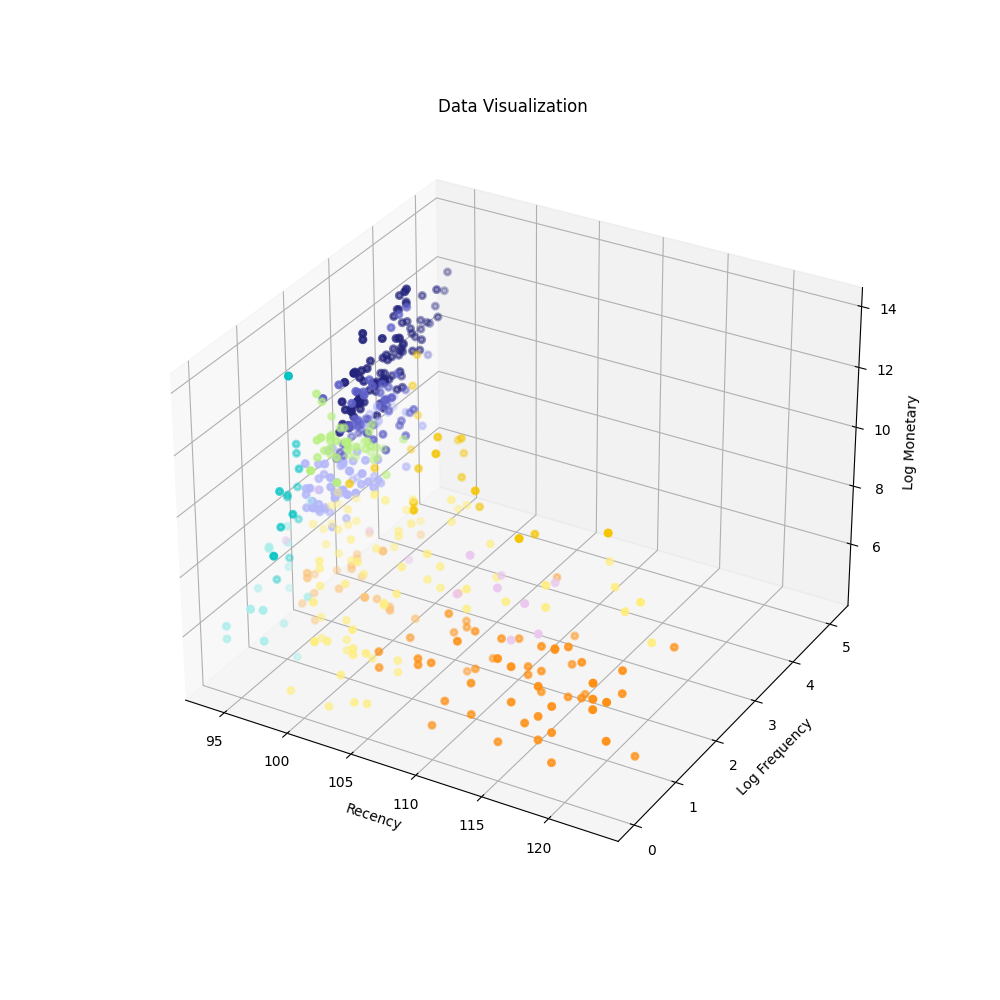

In [105]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

plt.title('Data Visualization')
ax.set_xlabel('Recency')
ax.set_ylabel('Log Frequency')
ax.set_zlabel('Log Monetary')

ax.scatter(xChampion, logyChampion, logzChampion, c='#23237C', linewidth=2);
ax.scatter(xLoyal, logyLoyal, logzLoyal, c='#6061C9', linewidth=2);
ax.scatter(xPoLoyal, logyPoLoyal, logzPoLoyal, c='#B5B8F9', linewidth=2);
ax.scatter(xNewCust, logyNewCust, logzNewCust, c='#ABEEEC', linewidth=2);
ax.scatter(xPromis, logyPromis, logzPromis, c='#01C4C3', linewidth=2);
ax.scatter(xNeedAttent, logyNeedAttent, logzNeedAttent, c='#B8F080', linewidth=2);
ax.scatter(xAbout, logyAbout, logzAbout, c='#FBC57E', linewidth=2);
ax.scatter(xrisk, logyrisk, logzrisk, c='#F4C500', linewidth=2);
ax.scatter(xCantlose, logyCantlose, logzCantlose, c='#EBC9EE', linewidth=2);
ax.scatter(xHibernate, logyHibernate, logzHibernate, c='#FFEE7C', linewidth=2);
ax.scatter(xLost, logyLost, logzLost, c='#FF9014', linewidth=2);

#### RF Graph

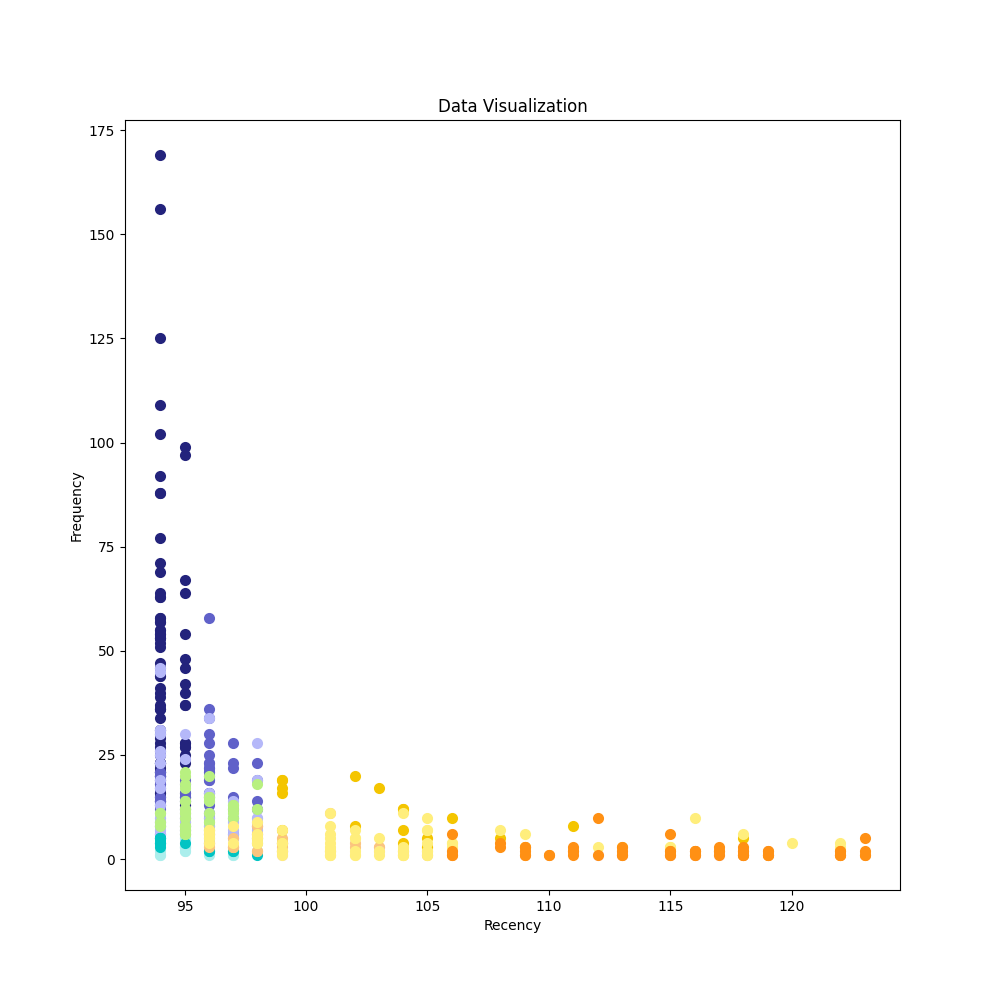

In [106]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.title('Data Visualization')
ax.set_ylabel('Frequency')
ax.set_xlabel('Recency')


ax.scatter(xChampion, yChampion,  c='#23237C', linewidth=2);
ax.scatter(xLoyal, yLoyal,  c='#6061C9', linewidth=2);
ax.scatter(xPoLoyal, yPoLoyal,  c='#B5B8F9', linewidth=2);
ax.scatter(xNewCust, yNewCust,  c='#ABEEEC', linewidth=2);
ax.scatter(xPromis, yPromis,  c='#01C4C3', linewidth=2);
ax.scatter(xNeedAttent, yNeedAttent,  c='#B8F080', linewidth=2);
ax.scatter(xAbout, yAbout,  c='#FBC57E', linewidth=2);
ax.scatter(xrisk, yrisk,  c='#F4C500', linewidth=2);
ax.scatter(xCantlose, yCantlose,  c='#EBC9EE', linewidth=2);
ax.scatter(xHibernate, yHibernate,  c='#FFEE7C', linewidth=2);
ax.scatter(xLost, yLost,  c='#FF9014', linewidth=2);

#### Rlog(F) Graph

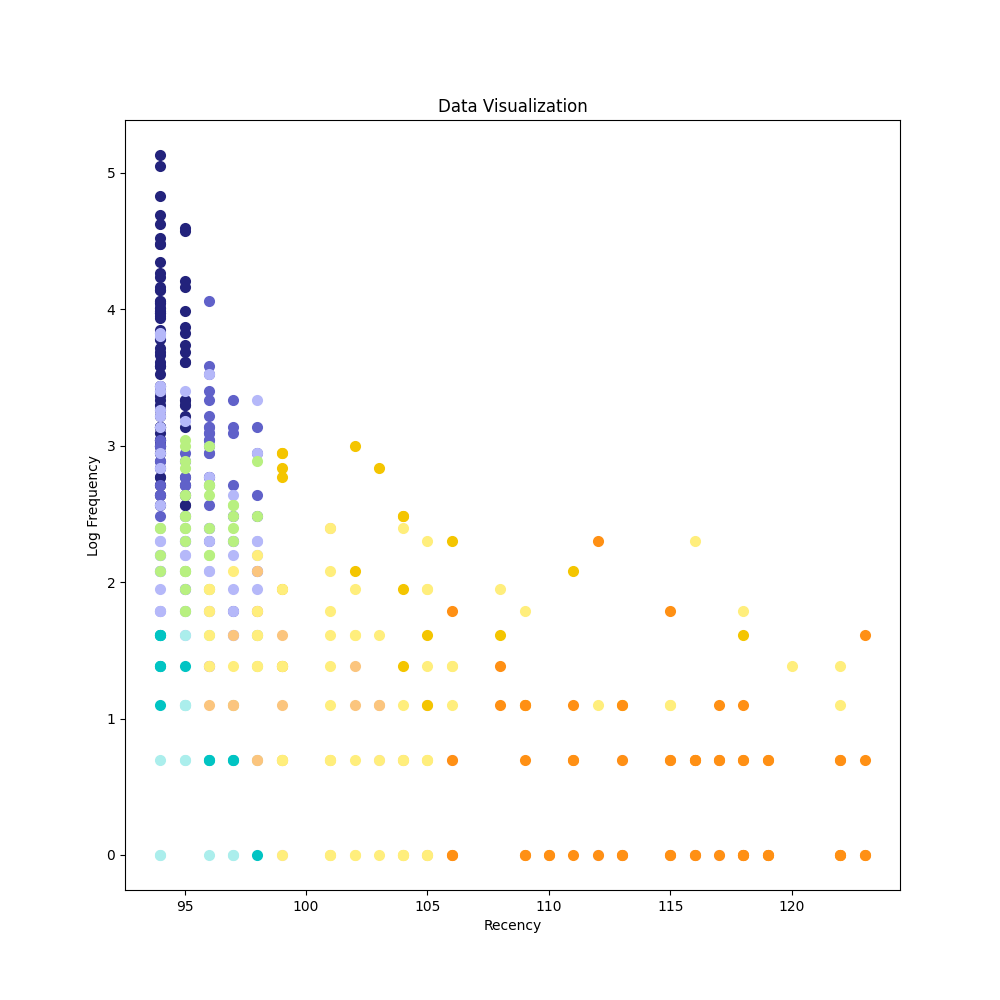

In [107]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()


plt.title('Data Visualization')
ax.set_ylabel('Log Frequency')
ax.set_xlabel('Recency')


ax.scatter(xChampion, logyChampion,  c='#23237C', linewidth=2);
ax.scatter(xLoyal, logyLoyal,  c='#6061C9', linewidth=2);
ax.scatter(xPoLoyal, logyPoLoyal,  c='#B5B8F9', linewidth=2);
ax.scatter(xNewCust, logyNewCust,  c='#ABEEEC', linewidth=2);
ax.scatter(xPromis, logyPromis,  c='#01C4C3', linewidth=2);
ax.scatter(xNeedAttent, logyNeedAttent,  c='#B8F080', linewidth=2);
ax.scatter(xAbout, logyAbout,  c='#FBC57E', linewidth=2);
ax.scatter(xrisk, logyrisk,  c='#F4C500', linewidth=2);
ax.scatter(xCantlose, logyCantlose,  c='#EBC9EE', linewidth=2);
ax.scatter(xHibernate, logyHibernate,  c='#FFEE7C', linewidth=2);
ax.scatter(xLost, logyLost,  c='#FF9014', linewidth=2);

#### RM Graph

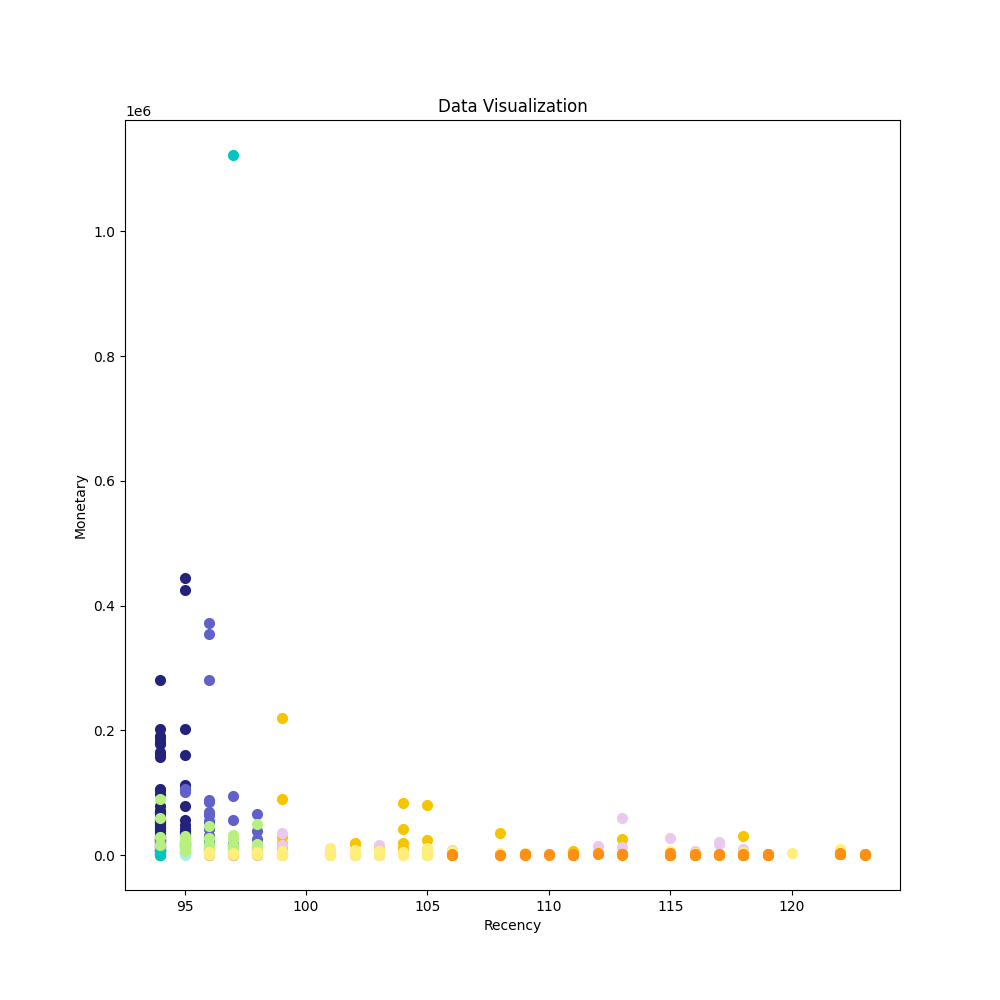

In [108]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.title('Data Visualization')
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')

ax.scatter( xChampion, zChampion, c='#23237C', linewidth=2);
ax.scatter( xLoyal, zLoyal, c='#6061C9', linewidth=2);
ax.scatter( xPoLoyal, zPoLoyal, c='#B5B8F9', linewidth=2);
ax.scatter( xNewCust, zNewCust, c='#ABEEEC', linewidth=2);
ax.scatter( xPromis, zPromis, c='#01C4C3', linewidth=2);
ax.scatter( xNeedAttent, zNeedAttent, c='#B8F080', linewidth=2);
ax.scatter( xAbout, zAbout, c='#FBC57E', linewidth=2);
ax.scatter( xrisk, zrisk, c='#F4C500', linewidth=2);
ax.scatter( xCantlose, zCantlose, c='#EBC9EE', linewidth=2);
ax.scatter( xHibernate, zHibernate, c='#FFEE7C', linewidth=2);
ax.scatter( xLost, zLost, c='#FF9014', linewidth=2);

#### Rlog(M) Graph

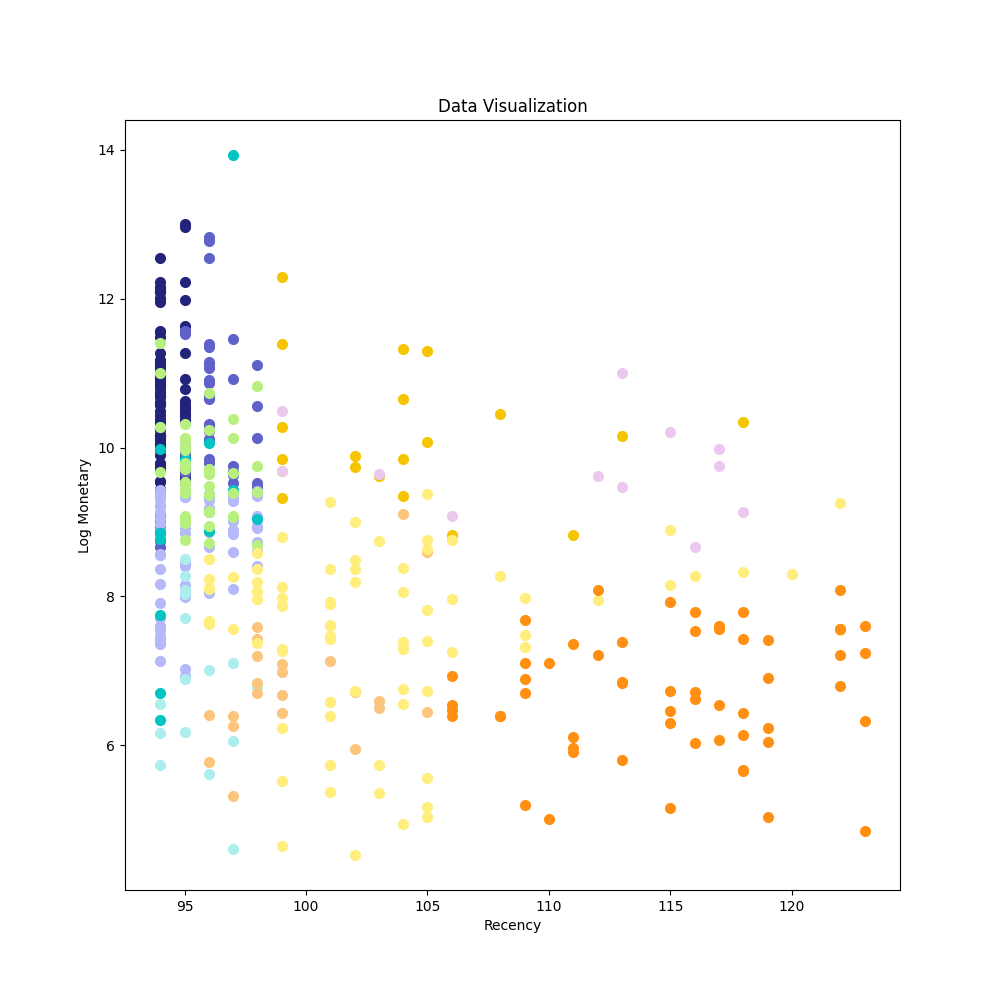

In [109]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.title('Data Visualization')
ax.set_xlabel('Recency')
ax.set_ylabel('Log Monetary')

ax.scatter( xChampion, logzChampion, c='#23237C', linewidth=2);
ax.scatter( xLoyal, logzLoyal, c='#6061C9', linewidth=2);
ax.scatter( xPoLoyal, logzPoLoyal, c='#B5B8F9', linewidth=2);
ax.scatter( xNewCust, logzNewCust, c='#ABEEEC', linewidth=2);
ax.scatter( xPromis, logzPromis, c='#01C4C3', linewidth=2);
ax.scatter( xNeedAttent, logzNeedAttent, c='#B8F080', linewidth=2);
ax.scatter( xAbout, logzAbout, c='#FBC57E', linewidth=2);
ax.scatter( xrisk, logzrisk, c='#F4C500', linewidth=2);
ax.scatter( xCantlose, logzCantlose, c='#EBC9EE', linewidth=2);
ax.scatter( xHibernate, logzHibernate, c='#FFEE7C', linewidth=2);
ax.scatter( xLost, logzLost, c='#FF9014', linewidth=2);

#### FM Graph

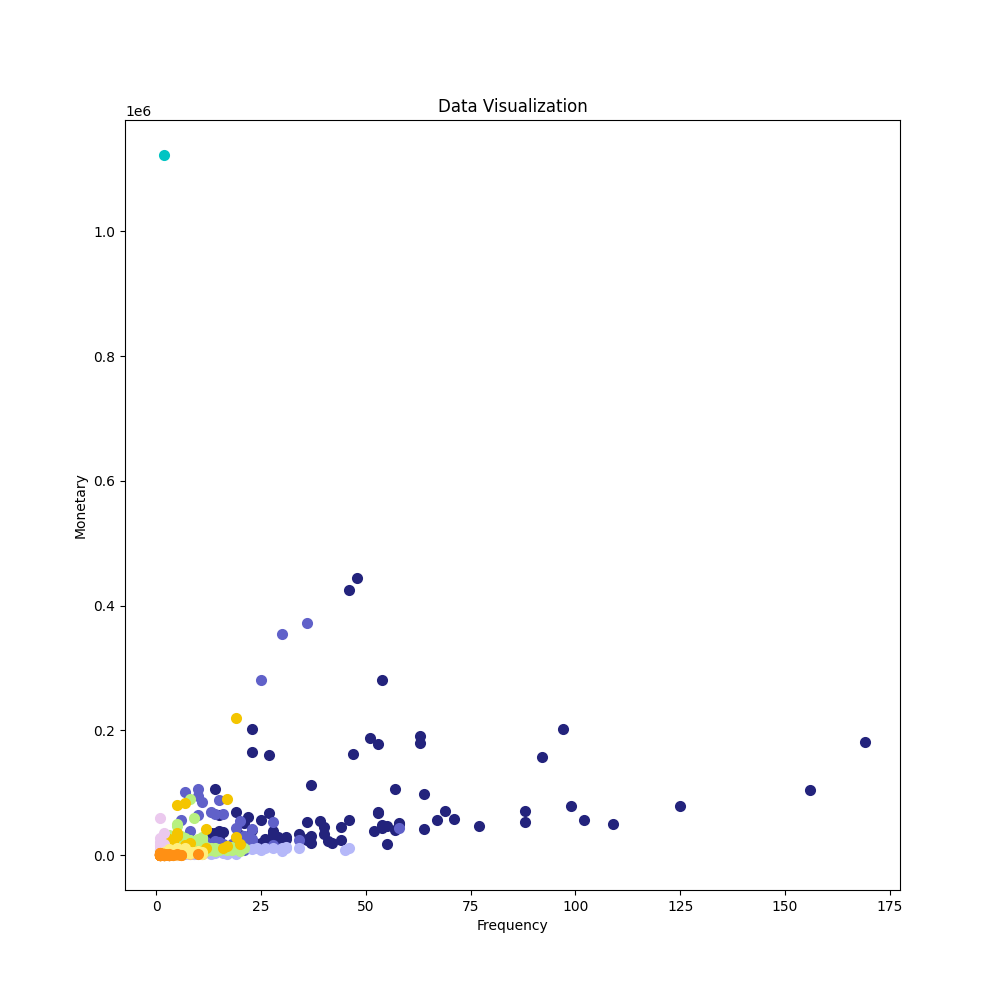

In [110]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.title('Data Visualization')
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')

ax.scatter(yChampion,  zChampion, c='#23237C', linewidth=2);
ax.scatter(yLoyal,  zLoyal, c='#6061C9', linewidth=2);
ax.scatter(yPoLoyal,  zPoLoyal, c='#B5B8F9', linewidth=2);
ax.scatter(yNewCust,  zNewCust, c='#ABEEEC', linewidth=2);
ax.scatter(yPromis,  zPromis, c='#01C4C3', linewidth=2);
ax.scatter(yNeedAttent,  zNeedAttent, c='#B8F080', linewidth=2);
ax.scatter(yAbout,  zAbout, c='#FBC57E', linewidth=2);
ax.scatter(yrisk,  zrisk, c='#F4C500', linewidth=2);
ax.scatter(yCantlose,  zCantlose, c='#EBC9EE', linewidth=2);
ax.scatter(yHibernate,  zHibernate, c='#FFEE7C', linewidth=2);
ax.scatter(yLost,  zLost, c='#FF9014', linewidth=2);

#### log(F)log(M) Graph

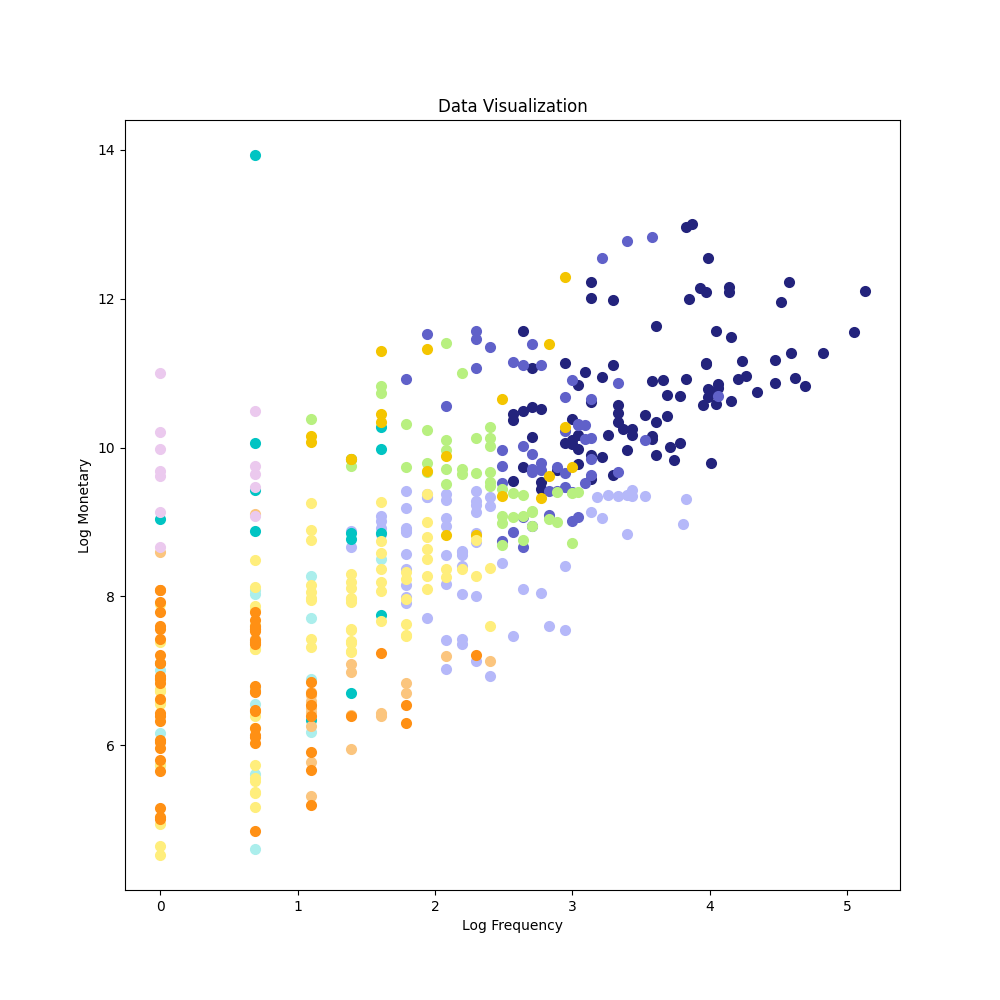

In [111]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()

plt.title('Data Visualization')
ax.set_xlabel('Log Frequency')
ax.set_ylabel('Log Monetary')

ax.scatter(logyChampion, logzChampion, c='#23237C', linewidth=2);
ax.scatter(logyLoyal, logzLoyal, c='#6061C9', linewidth=2);
ax.scatter(logyPoLoyal, logzPoLoyal, c='#B5B8F9', linewidth=2);
ax.scatter(logyNewCust, logzNewCust, c='#ABEEEC', linewidth=2);
ax.scatter(logyPromis, logzPromis, c='#01C4C3', linewidth=2);
ax.scatter(logyNeedAttent, logzNeedAttent, c='#B8F080', linewidth=2);
ax.scatter(logyAbout, logzAbout, c='#FBC57E', linewidth=2);
ax.scatter(logyrisk, logzrisk, c='#F4C500', linewidth=2);
ax.scatter(logyCantlose, logzCantlose, c='#EBC9EE', linewidth=2);
ax.scatter(logyHibernate, logzHibernate, c='#FFEE7C', linewidth=2);
ax.scatter(logyLost, logzLost, c='#FF9014', linewidth=2);

#### RFM Mean

In [112]:
segmented_rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3           115.0       1.3    635.6    29
4           109.8       1.9   1099.4    44
5           104.7       2.9   2117.5    39
6           105.7       3.8   5839.5    30
7           100.1       4.4   7654.7    33
8            98.4       5.6   9033.6    30
9            97.2       8.6  43058.3    34
10           96.1      10.0  14386.1    41
11           95.8      13.8  27536.8    48
12           95.1      17.5  28304.4    35
13           94.6      24.0  51197.6    38
14           94.4      38.5  74713.7    31
15           94.0      63.1  92943.6    38

In [113]:
segmented_rfm

Year Month CalendarDay  Customer_ID  Recency  Frequency    Monetary  \
0    2021    10  2021-10-30            1       94         30    21276.23   
1    2021    10  2021-10-30            2       94         19    23436.00   
2    2021    10  2021-10-26            3       98          8     7684.00   
3    2021    10  2021-10-29            4       95          7   100902.08   
4    2021    10  2021-10-30            5       94        125    78317.55   
5    2021    10  2021-10-18            8      106          4     2900.00   
6    2021    10  2021-10-04            9      120          4     4052.79   
7    2021    10  2021-10-28           10       96         15    88244.00   
8    2021    10  2021-10-25           13       99          2     2640.00   
9    2021    10  2021-10-25           14       99         19   219270.80   
10   2021    10  2021-10-25           15       99          4     2910.00   
11   2021    10  2021-10-23           16      101          1     2702.80   
12   2021    10  2021-10-11           17      113          3    25813.20   
13   2021    10  2021-10-29           18       95          8    13499.50   
14   2021    10  2021-10-27           19       97          7    11390.00   
15   2021    10  2021-10-27           20       97         12    17247.67   
16   2021    10  2021-10-30           22       94         27    67166.00   
17   2021    10  2021-10-30           23       94         55    45913.92   
18   2021    10  2021-10-26           24       98          2     1980.00   
19   2021    10  2021-10-23           25      101          2     2040.00   
20   2021    10  2021-10-19           28      105          2      176.00   
21   2021    10  2021-10-26           29       98         10    12381.00   
22   2021    10  2021-10-21           31      103          5     6272.30   
23   2021    10  2021-10-30           32       94         18    16271.27   
24   2021    10  2021-10-18           34      106         10     6819.00   
25   2021    10  2021-10-19           35      105          1     5400.00   
26   2021    10  2021-10-30           36       94         21    21494.18   
27   2021    10  2021-10-30           39       94         17     1998.88   
28   2021    10  2021-10-30           40       94         28    30875.00   
29   2021    10  2021-10-28           41       96         23    42060.00   
30   2021    10  2021-10-28           42       96          3      322.71   
31   2021    10  2021-10-02           44      122          3    10470.00   
32   2021    10  2021-10-29           45       95          7    17832.00   
33   2021    10  2021-10-28           46       96         16    66520.00   
34   2021    10  2021-10-30           47       94         23    40495.34   
35   2021    10  2021-10-22           49      102          4      385.52   
36   2021    10  2021-10-18           50      106          2      650.00   
37   2021    10  2021-10-13           52      111          2     1579.44   
38   2021    10  2021-10-30           55       94         58    51638.95   
39   2021    10  2021-10-29           56       95         42    18645.00   
40   2021    10  2021-10-30           58       94        156   104347.95   
41   2021    10  2021-10-28           59       96          7     3318.00   
42   2021    10  2021-10-28           62       96          7    15788.00   
43   2021    10  2021-10-28           63       96         10     9250.00   
44   2021    10  2021-10-07           65      117          1    21532.71   
45   2021    10  2021-10-29           66       95         14   105320.00   
46   2021    10  2021-10-25           67       99          4     1074.16   
47   2021    10  2021-10-30           70       94          6    12234.40   
48   2021    10  2021-10-30           71       94         63   191509.66   
49   2021    10  2021-10-09           75      115          6      544.57   
50   2021    10  2021-10-26           76       98         14    66428.86   
51   2021    10  2021-10-29           77       95    

## Regression

In [114]:
segmented_rfm

Year Month CalendarDay  Customer_ID  Recency  Frequency    Monetary  \
0    2021    10  2021-10-30            1       94         30    21276.23   
1    2021    10  2021-10-30            2       94         19    23436.00   
2    2021    10  2021-10-26            3       98          8     7684.00   
3    2021    10  2021-10-29            4       95          7   100902.08   
4    2021    10  2021-10-30            5       94        125    78317.55   
5    2021    10  2021-10-18            8      106          4     2900.00   
6    2021    10  2021-10-04            9      120          4     4052.79   
7    2021    10  2021-10-28           10       96         15    88244.00   
8    2021    10  2021-10-25           13       99          2     2640.00   
9    2021    10  2021-10-25           14       99         19   219270.80   
10   2021    10  2021-10-25           15       99          4     2910.00   
11   2021    10  2021-10-23           16      101          1     2702.80   
12   2021    10  2021-10-11           17      113          3    25813.20   
13   2021    10  2021-10-29           18       95          8    13499.50   
14   2021    10  2021-10-27           19       97          7    11390.00   
15   2021    10  2021-10-27           20       97         12    17247.67   
16   2021    10  2021-10-30           22       94         27    67166.00   
17   2021    10  2021-10-30           23       94         55    45913.92   
18   2021    10  2021-10-26           24       98          2     1980.00   
19   2021    10  2021-10-23           25      101          2     2040.00   
20   2021    10  2021-10-19           28      105          2      176.00   
21   2021    10  2021-10-26           29       98         10    12381.00   
22   2021    10  2021-10-21           31      103          5     6272.30   
23   2021    10  2021-10-30           32       94         18    16271.27   
24   2021    10  2021-10-18           34      106         10     6819.00   
25   2021    10  2021-10-19           35      105          1     5400.00   
26   2021    10  2021-10-30           36       94         21    21494.18   
27   2021    10  2021-10-30           39       94         17     1998.88   
28   2021    10  2021-10-30           40       94         28    30875.00   
29   2021    10  2021-10-28           41       96         23    42060.00   
30   2021    10  2021-10-28           42       96          3      322.71   
31   2021    10  2021-10-02           44      122          3    10470.00   
32   2021    10  2021-10-29           45       95          7    17832.00   
33   2021    10  2021-10-28           46       96         16    66520.00   
34   2021    10  2021-10-30           47       94         23    40495.34   
35   2021    10  2021-10-22           49      102          4      385.52   
36   2021    10  2021-10-18           50      106          2      650.00   
37   2021    10  2021-10-13           52      111          2     1579.44   
38   2021    10  2021-10-30           55       94         58    51638.95   
39   2021    10  2021-10-29           56       95         42    18645.00   
40   2021    10  2021-10-30           58       94        156   104347.95   
41   2021    10  2021-10-28           59       96          7     3318.00   
42   2021    10  2021-10-28           62       96          7    15788.00   
43   2021    10  2021-10-28           63       96         10     9250.00   
44   2021    10  2021-10-07           65      117          1    21532.71   
45   2021    10  2021-10-29           66       95         14   105320.00   
46   2021    10  2021-10-25           67       99          4     1074.16   
47   2021    10  2021-10-30           70       94          6    12234.40   
48   2021    10  2021-10-30           71       94         63   191509.66   
49   2021    10  2021-10-09           75      115          6      544.57   
50   2021    10  2021-10-26           76       98         14    66428.86   
51   2021    10  2021-10-29           77       95    

In [115]:
train_test_data = segmented_rfm.copy()
train_test_data.drop(columns=['Customer_ID','FM_Avg','R_Score','F_Score','M_Score','FM_Score','RFM_Segment','RFM_Score'],inplace=True)
train_test_data

Year Month CalendarDay  Recency  Frequency    Monetary            Class
0    2021    10  2021-10-30       94         30    21276.23         Champion
1    2021    10  2021-10-30       94         19    23436.00         Champion
2    2021    10  2021-10-26       98          8     7684.00  Potential Loyal
3    2021    10  2021-10-29       95          7   100902.08            Loyal
4    2021    10  2021-10-30       94        125    78317.55         Champion
5    2021    10  2021-10-18      106          4     2900.00      Hibernating
6    2021    10  2021-10-04      120          4     4052.79      Hibernating
7    2021    10  2021-10-28       96         15    88244.00            Loyal
8    2021    10  2021-10-25       99          2     2640.00      Hibernating
9    2021    10  2021-10-25       99         19   219270.80          At risk
10   2021    10  2021-10-25       99          4     2910.00      Hibernating
11   2021    10  2021-10-23      101          1     2702.80      Hibernating
12   2021    10  2021-10-11      113          3    25813.20          At risk
13   2021    10  2021-10-29       95          8    13499.50   Need Attention
14   2021    10  2021-10-27       97          7    11390.00  Potential Loyal
15   2021    10  2021-10-27       97         12    17247.67            Loyal
16   2021    10  2021-10-30       94         27    67166.00         Champion
17   2021    10  2021-10-30       94         55    45913.92         Champion
18   2021    10  2021-10-26       98          2     1980.00   About to sleep
19   2021    10  2021-10-23      101          2     2040.00      Hibernating
20   2021    10  2021-10-19      105          2      176.00      Hibernating
21   2021    10  2021-10-26       98         10    12381.00  Potential Loyal
22   2021    10  2021-10-21      103          5     6272.30      Hibernating
23   2021    10  2021-10-30       94         18    16271.27         Champion
24   2021    10  2021-10-18      106         10     6819.00          At risk
25   2021    10  2021-10-19      105          1     5400.00   About to sleep
26   2021    10  2021-10-30       94         21    21494.18         Champion
27   2021    10  2021-10-30       94         17     1998.88  Potential Loyal
28   2021    10  2021-10-30       94         28    30875.00         Champion
29   2021    10  2021-10-28       96         23    42060.00            Loyal
30   2021    10  2021-10-28       96          3      322.71   About to sleep
31   2021    10  2021-10-02      122          3    10470.00      Hibernating
32   2021    10  2021-10-29       95          7    17832.00   Need Attention
33   2021    10  2021-10-28       96         16    66520.00            Loyal
34   2021    10  2021-10-30       94         23    40495.34         Champion
35   2021    10  2021-10-22      102          4      385.52   About to sleep
36   2021    10  2021-10-18      106          2      650.00             Lost
37   2021    10  2021-10-13      111          2     1579.44             Lost
38   2021    10  2021-10-30       94         58    51638.95         Champion
39   2021    10  2021-10-29       95         42    18645.00         Champion
40   2021    10  2021-10-30       94        156   104347.95         Champion
41   2021    10  2021-10-28       96          7     3318.00      Hibernating
42   2021    10  2021-10-28       96          7    15788.00   Need Attention
43   2021    10  2021-10-28       96         10     9250.00  Potential Loyal
44   2021    10  2021-10-07      117          1    21532.71  Can't lose them
45   2021    10  2021-10-29       95         14   105320.00         Champion
46   2021    10  2021-10-25       99          4     1074.16   About to sleep
47   2021    10  2021-10-30       94          6    12234.40  Potential Loyal
48   2021    10  2021-10-30       94         63   191509.66         Champion
49   2021    10  2021-10-09      115          6      544.57             Lost
50   2021    10  2021-10-26       98         14    66428.86            Loyal
5

In [116]:
# Champion > Loyal > Potential Loyal > 	New Customer > Promising > 	Need Attention > About to sleep > At risk	 > Can't lose them > Hibernating > Lost
train_test_data['Class'] = train_test_data['Class'].replace({'Champion':10, 'Loyal':9,'Potential Loyal':8,'New Customer':7,'Promising':6,'Need Attention':5,'About to sleep':4,'At risk':3,"Can't lose them":2,'Hibernating':1,'Lost':0})
train_test_data

Year Month CalendarDay  Recency  Frequency    Monetary  Class
0    2021    10  2021-10-30       94         30    21276.23     10
1    2021    10  2021-10-30       94         19    23436.00     10
2    2021    10  2021-10-26       98          8     7684.00      8
3    2021    10  2021-10-29       95          7   100902.08      9
4    2021    10  2021-10-30       94        125    78317.55     10
5    2021    10  2021-10-18      106          4     2900.00      1
6    2021    10  2021-10-04      120          4     4052.79      1
7    2021    10  2021-10-28       96         15    88244.00      9
8    2021    10  2021-10-25       99          2     2640.00      1
9    2021    10  2021-10-25       99         19   219270.80      3
10   2021    10  2021-10-25       99          4     2910.00      1
11   2021    10  2021-10-23      101          1     2702.80      1
12   2021    10  2021-10-11      113          3    25813.20      3
13   2021    10  2021-10-29       95          8    13499.50      5
14   2021    10  2021-10-27       97          7    11390.00      8
15   2021    10  2021-10-27       97         12    17247.67      9
16   2021    10  2021-10-30       94         27    67166.00     10
17   2021    10  2021-10-30       94         55    45913.92     10
18   2021    10  2021-10-26       98          2     1980.00      4
19   2021    10  2021-10-23      101          2     2040.00      1
20   2021    10  2021-10-19      105          2      176.00      1
21   2021    10  2021-10-26       98         10    12381.00      8
22   2021    10  2021-10-21      103          5     6272.30      1
23   2021    10  2021-10-30       94         18    16271.27     10
24   2021    10  2021-10-18      106         10     6819.00      3
25   2021    10  2021-10-19      105          1     5400.00      4
26   2021    10  2021-10-30       94         21    21494.18     10
27   2021    10  2021-10-30       94         17     1998.88      8
28   2021    10  2021-10-30       94         28    30875.00     10
29   2021    10  2021-10-28       96         23    42060.00      9
30   2021    10  2021-10-28       96          3      322.71      4
31   2021    10  2021-10-02      122          3    10470.00      1
32   2021    10  2021-10-29       95          7    17832.00      5
33   2021    10  2021-10-28       96         16    66520.00      9
34   2021    10  2021-10-30       94         23    40495.34     10
35   2021    10  2021-10-22      102          4      385.52      4
36   2021    10  2021-10-18      106          2      650.00      0
37   2021    10  2021-10-13      111          2     1579.44      0
38   2021    10  2021-10-30       94         58    51638.95     10
39   2021    10  2021-10-29       95         42    18645.00     10
40   2021    10  2021-10-30       94        156   104347.95     10
41   2021    10  2021-10-28       96          7     3318.00      1
42   2021    10  2021-10-28       96          7    15788.00      5
43   2021    10  2021-10-28       96         10     9250.00      8
44   2021    10  2021-10-07      117          1    21532.71      2
45   2021    10  2021-10-29       95         14   105320.00     10
46   2021    10  2021-10-25       99          4     1074.16      4
47   2021    10  2021-10-30       94          6    12234.40      8
48   2021    10  2021-10-30       94         63   191509.66     10
49   2021    10  2021-10-09      115          6      544.57      0
50   2021    10  2021-10-26       98         14    66428.86      9
51   2021    10  2021-10-29       95         28    35233.00     10
52   2021    10  2021-10-22      102          3      829.67      4
53   2021    10  2021-10-23      101          5    10594.10      1
54   2021    10  2021-10-25       99          5      619.68      4
55   2021    10  2021-10-29       95         10   105404.23      9
56   2021    10  2021-10-09      115          2      840.00      0
57   2021    10  2021-10-26       98          5     3190.00      1
58   2021    10  2021-10-28       96         15     

In [117]:
# split X and y into training and testing sets

# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
train_data,test_data=train_test_split(train_test_data,test_size=0.3,random_state=0)

In [118]:
train_data.shape

(329, 7)

In [119]:
test_data.shape

(141, 7)

In [120]:
# setup
reg = setup(data = train_test_data, target = 'Class', fold_shuffle=True, imputation_type='iterative')

AttributeError: 'Make_Time_Features' object has no attribute 'list_of_features'

In [43]:
# all the models that are available are 
models()

Name  \
ID                                            
lr                        Linear Regression   
lasso                      Lasso Regression   
ridge                      Ridge Regression   
en                              Elastic Net   
lar                  Least Angle Regression   
llar           Lasso Least Angle Regression   
omp             Orthogonal Matching Pursuit   
br                           Bayesian Ridge   
ard       Automatic Relevance Determination   
par            Passive Aggressive Regressor   
ransac              Random Sample Consensus   
tr                       TheilSen Regressor   
huber                       Huber Regressor   
kr                             Kernel Ridge   
svm               Support Vector Regression   
knn                   K Neighbors Regressor   
dt                  Decision Tree Regressor   
rf                  Random Forest Regressor   
et                    Extra Trees Regressor   
ada                      AdaBoost Regressor   
gbr             Gradient Boosting Regressor   
mlp                           MLP Regressor   
xgboost           Extreme Gradient Boosting   
lightgbm    Light Gradient Boosting Machine   
catboost                 CatBoost Regressor   

                                                  Reference  Turbo  
ID                                                                  
lr              sklearn.linear_model._base.LinearRegression   True  
lasso        sklearn.linear_model._coordinate_descent.Lasso   True  
ridge                     sklearn.linear_model._ridge.Ridge   True  
en        sklearn.linear_model._coordinate_descent.Elast...   True  
lar                  sklearn.linear_model._least_angle.Lars   True  
llar            sklearn.linear_model._least_angle.LassoLars   True  
omp       sklearn.linear_model._omp.OrthogonalMatchingPu...   True  
br                sklearn.linear_model._bayes.BayesianRidge   True  
ard               sklearn.linear_model._bayes.ARDRegression  False  
par       sklearn.linear_model._passive_aggressive.Passi...   True  
ransac         sklearn.linear_model._ransac.RANSACRegressor  False  
tr        sklearn.linear_model._theil_sen.TheilSenRegressor  False  
huber            sklearn.linear_model._huber.HuberRegressor   True  
kr                         sklearn.kernel_ridge.KernelRidge  False  
svm                                sklearn.svm._classes.SVR  False  
knn       sklearn.neighbors._regression.KNeighborsRegressor   True  
dt              sklearn.tree._classes.DecisionTreeRegressor   True  
rf           sklearn.ensemble._forest.RandomForestRegressor   True  
et             sklearn.ensemble._forest.ExtraTreesRegressor   True  
ada       sklearn.ensemble._weight_boosting.AdaBoostRegr...   True  
gbr          sklearn.ensemble._gb.GradientBoostingRegressor   True  
mlp            pycaret.internal.tunable.TunableMLPRegressor  False  
xgboost                        xgboost.sklearn.XGBRegressor   True  
lightgbm                     lightgbm.sklearn.LGBMRegressor   True  
catboost                    catboost.core.CatBoostRegressor   True

In [44]:
best = compare_models(fold = 5, turbo = True)

In [45]:
best

In [46]:
best_model = create_model(best)

In [47]:
best_model

In [48]:
tuned_model = tune_model(best_model)

In [49]:
tuned_model

In [50]:
plot_model(tuned_model)

IntProgress(value=0, description='Processing: ', max=5)

TypeError: unsupported operand type(s) for -: 'float' and 'str'

In [ ]:
plot_model(tuned_model, plot = 'error')

In [ ]:
plot_model(tuned_model, plot = 'feature')

In [ ]:
evaluate_model(tuned_model)

In [ ]:
predict_model(tuned_model)

In [ ]:
final_model = finalize_model(tuned_model)
final_model

In [ ]:
predict_model(final_model)

In [ ]:
prediction = predict_model(final_model, data = test_data)
prediction

In [ ]:
save_model(final_model, 'Final_Model')

In [ ]:
# loaded_model = load_model('Final_Model')
# print(loaded_model)

## Churn Monitoring

In [ ]:
churn_monitor = prediction.copy()
churn_monitor = churn_monitor.rename(columns = {'Class': 'Old_Class', 'Label': 'Predict_Class'}, inplace = False)
churn_monitor

In [217]:
churn_monitor['Predict_Class'] = churn_monitor['Predict_Class'].round().astype('int')
churn_monitor

Recency  Frequency    Monetary  Old_Class  Predict_Class
540       39         13     7554.77          1              1
467        3        114  1278440.00         10             10
355        6          3     2699.28          4              4
172       45          3     2618.21          1              1
637        1         47     9273.79          9              8
..       ...        ...         ...        ...            ...
676       34         13     1767.16          1              1
263        6        138   669840.00          9              9
463       96          4      606.99          0              0
267        1         63    87709.99         10             10
159        7         20    13132.20          8              8

[213 rows x 5 columns]

In [218]:
# Compare Class
churn_monitor['Monitor'] = (churn_monitor['Old_Class'] > churn_monitor['Predict_Class'])
churn_monitor['Monitor'] = churn_monitor['Monitor'].replace({True:'Churn', False:'Not_Churn'})
churn_monitor

Recency  Frequency    Monetary  Old_Class  Predict_Class    Monitor
540       39         13     7554.77          1              1  Not_Churn
467        3        114  1278440.00         10             10  Not_Churn
355        6          3     2699.28          4              4  Not_Churn
172       45          3     2618.21          1              1  Not_Churn
637        1         47     9273.79          9              8      Churn
..       ...        ...         ...        ...            ...        ...
676       34         13     1767.16          1              1  Not_Churn
263        6        138   669840.00          9              9  Not_Churn
463       96          4      606.99          0              0  Not_Churn
267        1         63    87709.99         10             10  Not_Churn
159        7         20    13132.20          8              8  Not_Churn

[213 rows x 6 columns]

In [219]:
# Churn
# Champion > Loyal > Potential Loyal > 	New Customer > Promising > 	Need Attention > About to sleep > At risk	 > Can't lose them > Hibernating > Lost

churn_monitor['Old_Class'] = churn_monitor['Old_Class'].replace({10:'Champion', 9:'Loyal', 8:'Potential Loyal', 7:'New Customer', 6:'Promising', 5:'Need Attention', 
                                                             4:'About to sleep', 3:'At risk', 2:"Can't lose them", 1:'Hibernating', 0:'Lost'})
churn_monitor['Predict_Class'] = churn_monitor['Predict_Class'].replace({10:'Champion', 9:'Loyal', 8:'Potential Loyal', 7:'New Customer', 6:'Promising', 5:'Need Attention', 
                                                             4:'About to sleep', 3:'At risk', 2:"Can't lose them", 1:'Hibernating', 0:'Lost'})
churn_monitor

Recency  Frequency  ...    Predict_Class    Monitor
540       39         13  ...      Hibernating  Not_Churn
467        3        114  ...         Champion  Not_Churn
355        6          3  ...   About to sleep  Not_Churn
172       45          3  ...      Hibernating  Not_Churn
637        1         47  ...  Potential Loyal      Churn
..       ...        ...  ...              ...        ...
676       34         13  ...      Hibernating  Not_Churn
263        6        138  ...            Loyal  Not_Churn
463       96          4  ...             Lost  Not_Churn
267        1         63  ...         Champion  Not_Churn
159        7         20  ...  Potential Loyal  Not_Churn

[213 rows x 6 columns]

In [220]:
customer_churn = churn_monitor[churn_monitor['Monitor'].isin(['Churn'])]
customer_churn

Recency  Frequency    Monetary        Old_Class    Predict_Class Monitor
637        1         47     9273.79            Loyal  Potential Loyal   Churn
346       54         30     6042.00          At risk      Hibernating   Churn
683        5         11     4408.96  Potential Loyal     New Customer   Churn
505       69         18    19714.49          At risk  Can't lose them   Churn
271       88          5  2219724.00          At risk  Can't lose them   Churn
358       14          5     7425.00  Potential Loyal     New Customer   Churn
85        60         15     8584.00          At risk  Can't lose them   Churn
142       25          7     1130.07   About to sleep          At risk   Churn
375       34          6        0.00   About to sleep          At risk   Churn
10        18          8     9565.42  Potential Loyal     New Customer   Churn
656       48          4      299.06   About to sleep          At risk   Churn
18         5         28    45490.00            Loyal  Potential Loyal   Churn
337        3         25    18251.57  Potential Loyal     New Customer   Churn
283       42          7     1253.85   About to sleep          At risk   Churn
365        5          6    59325.00        Promising   Need Attention   Churn
502        1         27    30922.11            Loyal     New Customer   Churn
332       78         38    13207.52          At risk  Can't lose them   Churn
432       91          2     7419.34  Can't lose them      Hibernating   Churn
492        6         28    42985.00            Loyal  Potential Loyal   Churn
294        1         35    41661.87         Champion            Loyal   Churn
140       45          4      660.78   About to sleep          At risk   Churn
417        1         57    31311.30         Champion            Loyal   Churn
77        81          7     2470.58      Hibernating             Lost   Churn
272       98         28    11449.00          At risk  Can't lose them   Churn
333       69          5     3750.00      Hibernating             Lost   Churn
489        4         18   279790.00            Loyal  Potential Loyal   Churn
705        6          1     1209.60     New Customer        Promising   Churn
532       34         35    28312.90          At risk  Can't lose them   Churn